# Imports

In [122]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as line
import osmnx as ox
from shapely.ops import unary_union

import util

# Data

Considering [Boulder's Low-Stress Walk and Bike Network Plan,](https://bouldercolorado.gov/projects/low-stress-walk-and-bike-network-plan) by [this paper:](https://bouldercolorado.gov/media/4530/download?inline=)

On page 34, the paper indicates that roads are chosen based on the following criteria:
* Equity index; areas with a lower equity index are valued more. Here is [Denver's equity index data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-equity-index-2020-neighborhood)
* Population and employment density; higher density neighborhoods are valued more.
  * Population and employment density are considered as part of the [Pedestrian Demand Index.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-pedestrian-demand-index)
* Density of crashes; more heavily weighted for pedestrian or bicyclist-involved crashes. Here is [Denver's crash data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents)
* Key destinations; the paper specifies parks, schools, and high-frequency transit stops, though it also indicates libraries, fitness centers, trailheads, restaurants, cafes, and grocery stores.
  * [Here](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-parks) is park data, [here](https://mygeodata.cloud/data/download/osm/schools/united-states-of-america--colorado/denver-county/denver) is school data, and [here](https://gis-rtd-denver.opendata.arcgis.com/maps/e14366d810644a3c95a4f3770799bd54/about) is RTD transit stop data.

# Neigborhood Selection

## Equity Data

Storing equity data.

In [123]:
equity_data = gpd.read_file("../data/equity_index_2020___neighborhood.gdb", driver="OpenFileGDB")
equity_data.head()

NBRHD_NAME  SOCIOECON_SCORE  ACCESSTOCARE_SCORE  MORBIDITY_SCORE  \
0  University Hills              4.0                 4.5              2.5   
1       Harvey Park              2.0                 2.5              2.0   
2           Mar Lee              2.0                 1.5              2.5   
3       East Colfax              1.5                 1.5              3.5   
4      Capitol Hill              4.0                 2.5              4.0   

   MORTALITY_SCORE  BUILTENV_SCORE  OVERALLEQUITY_SCORE  SHAPE_Length  \
0              3.0             3.5                  3.5      0.115736   
1              3.0             1.5                  2.2      0.105342   
2              2.0             3.5                  2.3      0.085462   
3              1.0             2.0                  1.9      0.073874   
4              1.0             4.0                  3.1      0.054472   

   SHAPE_Area                                           geometry  
0    0.000395  MULTIPOLYGON (((-104.93398 39.67845, -104.9339...  
1    0.000458  MULTIPOLYGON (((-105.02511 39.66772, -105.0260...  
2    0.000410  MULTIPOLYGON (((-105.02506 39.69675, -105.0250...  
3    0.000291  MULTIPOLYGON (((-104.88466 39.74746, -104.8846...  
4    0.000184  MULTIPOLYGON (((-104.97341 39.74003, -104.9729...

Plotting neighborhoods by overall equity score.

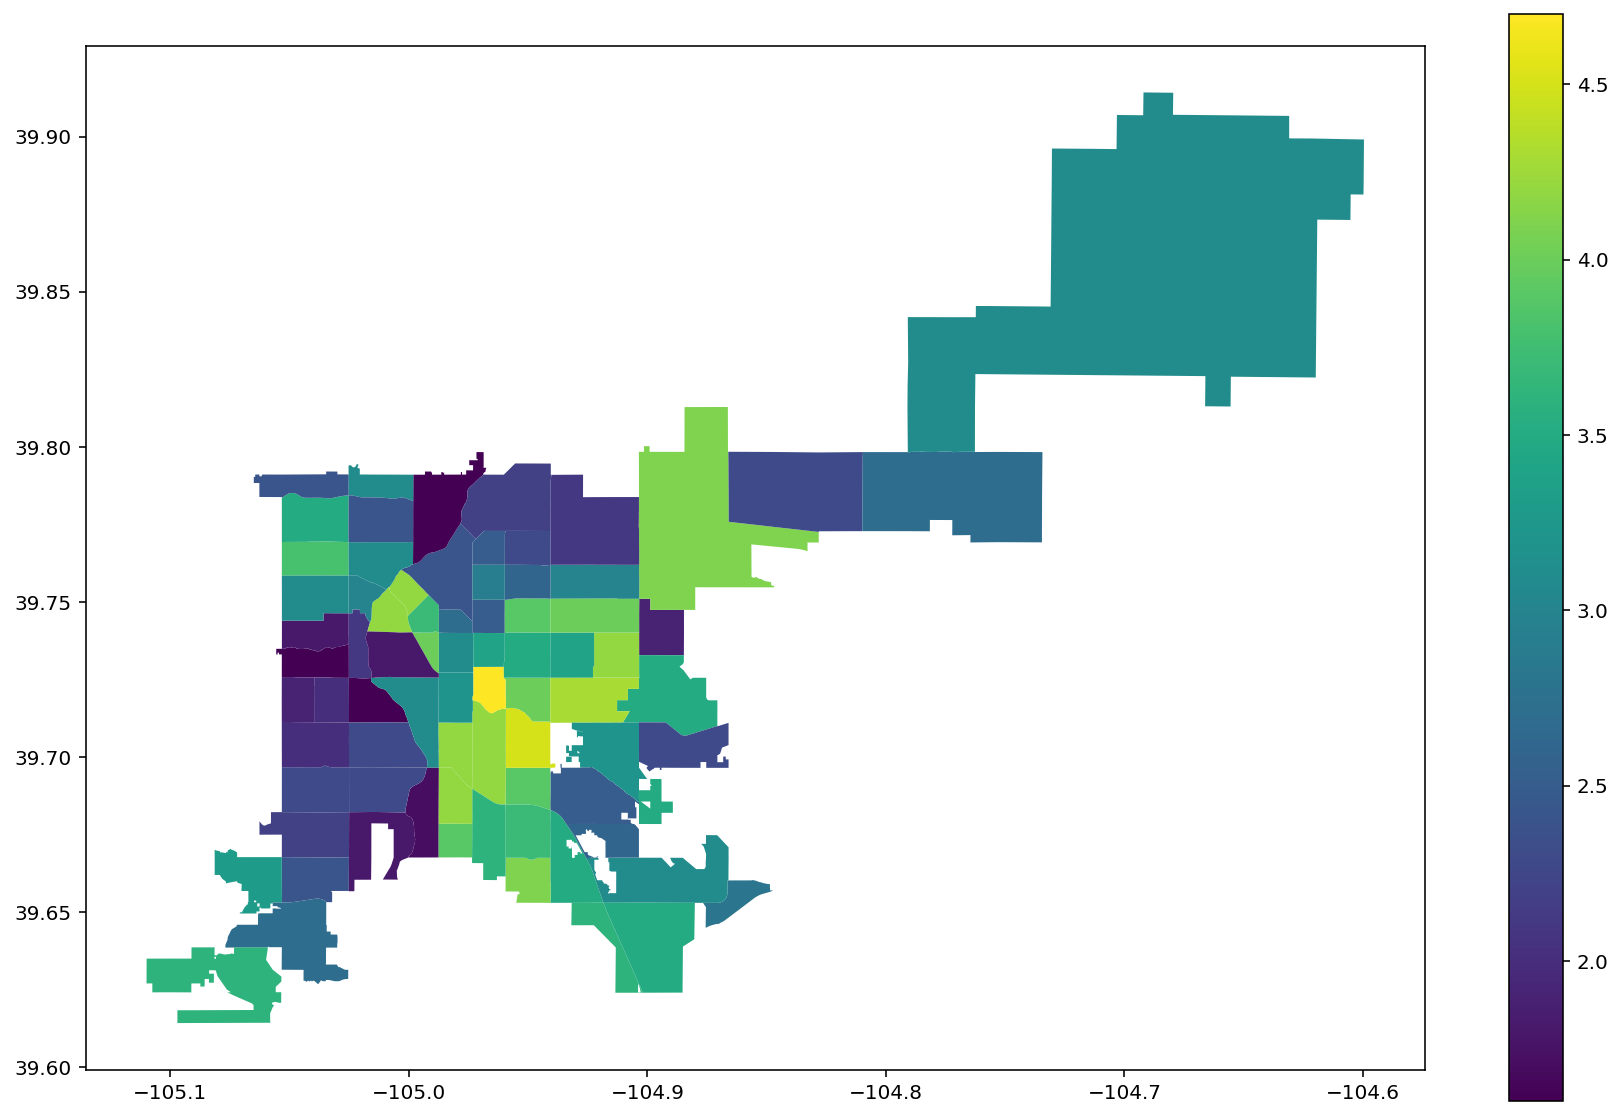

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="OVERALLEQUITY_SCORE", ax=ax, legend=True);

## Pedestrian Demand Data

Storing pedestrian demand data.

In [125]:
pedestrian_data = gpd.read_file("../data/pedestrian_demand_index.gdb", driver="OpenFileGDB")
pedestrian_data.head()

GEOID10  PDI_Score PDI_Ranking  SHAPE_Length  SHAPE_Area  \
0  0803100412146         10        HIGH      0.005259    0.000002   
1  0803100409310          8        HIGH      0.033493    0.000064   
2  0803100410310          1         LOW      0.031635    0.000046   
3  0803100407030          8        HIGH      0.040299    0.000073   
4  0803100410130          8        HIGH      0.039525    0.000073   

                                            geometry  
0  MULTIPOLYGON (((-104.99272 39.74744, -104.9929...  
1  MULTIPOLYGON (((-104.95938 39.66789, -104.9593...  
2  MULTIPOLYGON (((-104.85573 39.66044, -104.8556...  
3  MULTIPOLYGON (((-104.89524 39.73595, -104.8952...  
4  MULTIPOLYGON (((-104.91274 39.67846, -104.9127...

Plotting neighborhoods by pedestrian demand index score.

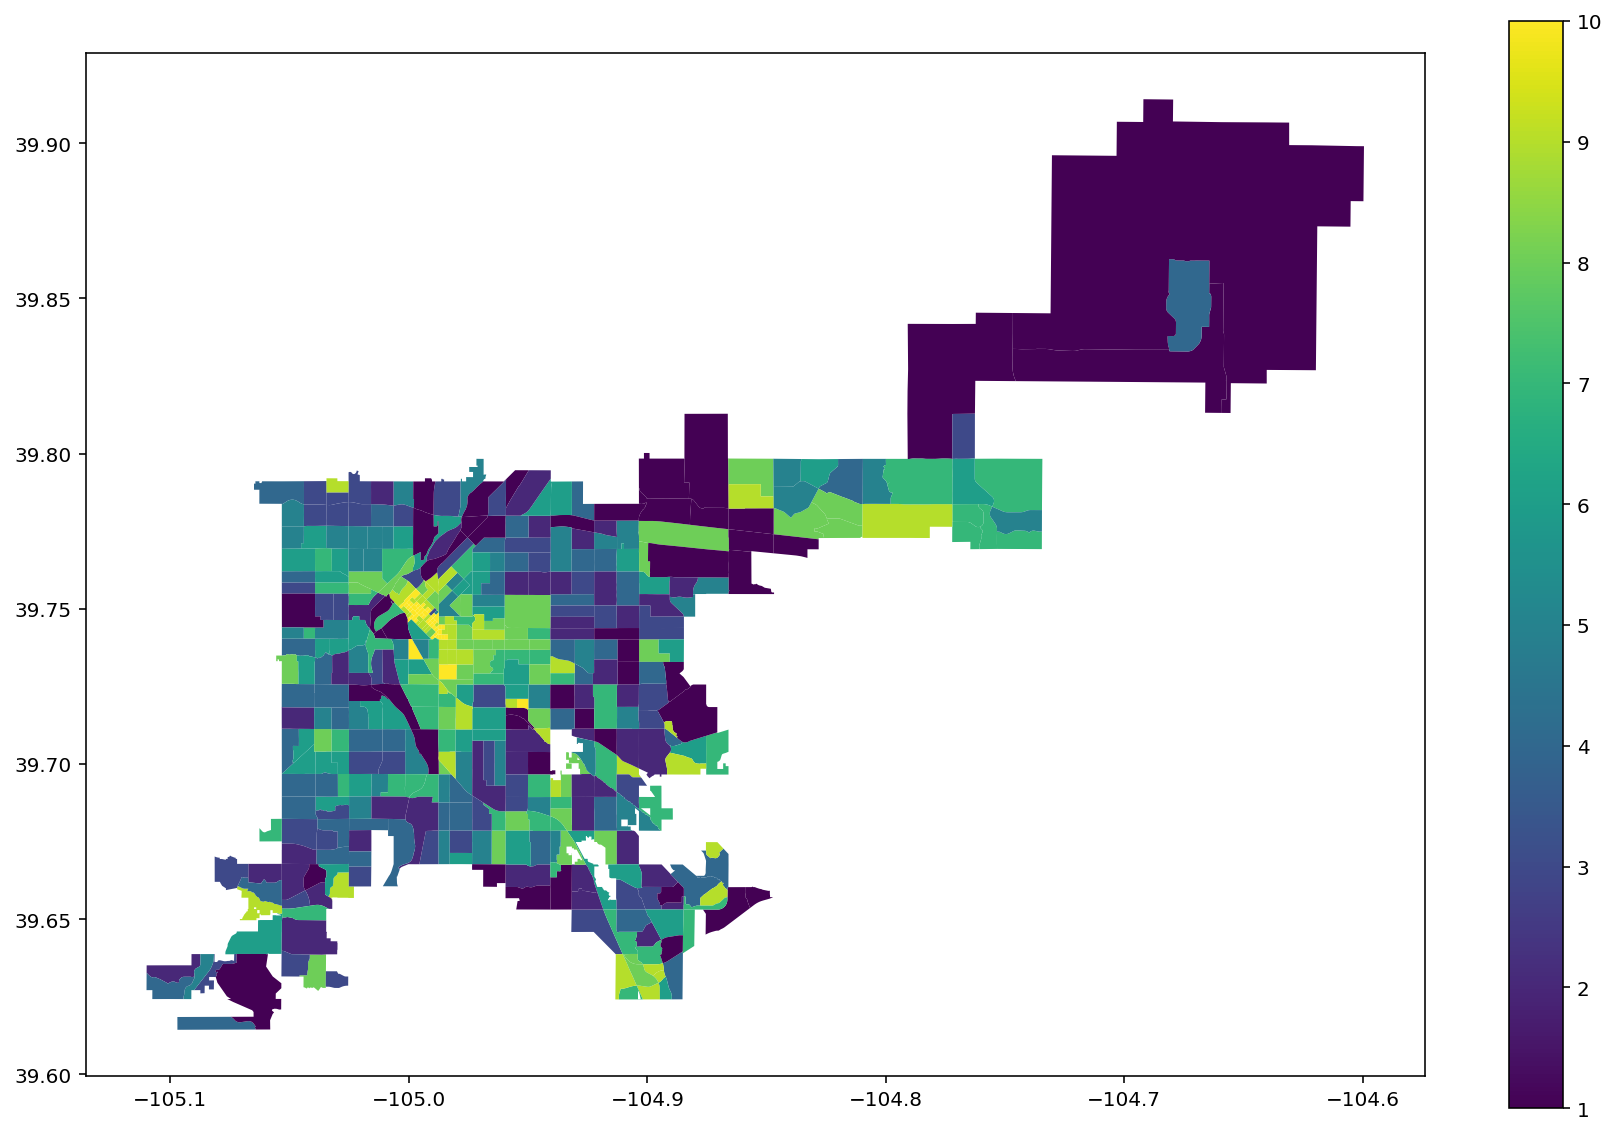

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
pedestrian_data.plot(column="PDI_Score", ax=ax, legend=True);

## Merging Equity and Pedestrian Demand

Adding column "EQUITY_SCORE_10" scaling overall equity score so that its max value is 10.

In [127]:
equity_score_10 = equity_data["OVERALLEQUITY_SCORE"]
equity_score_10 = (equity_score_10 / max(equity_score_10)) * 10
equity_data.insert(7, "EQUITY_SCORE_10", equity_score_10, False)

Merging equity data and pedestrian data. This merge uses predicate "intersects," so some pedestrian data entries may be counted multiple times if they intersect with multiple equity data entries.

In [128]:
equity_ped_data = equity_data.sjoin(pedestrian_data)
equity_ped_data.head()

NBRHD_NAME  SOCIOECON_SCORE  ACCESSTOCARE_SCORE  MORBIDITY_SCORE  \
0   University Hills              4.0                 4.5              2.5   
62    Southmoor Park              4.0                 4.5              3.0   
63     Hampden South              4.5                 4.0              2.5   
0   University Hills              4.0                 4.5              2.5   
61           Hampden              3.0                 3.0              3.0   

    MORTALITY_SCORE  BUILTENV_SCORE  OVERALLEQUITY_SCORE  EQUITY_SCORE_10  \
0               3.0             3.5                  3.5         7.446809   
62              5.0             1.5                  3.6         7.659575   
63              4.0             2.5                  3.5         7.446809   
0               3.0             3.5                  3.5         7.446809   
61              4.0             2.5                  3.1         6.595745   

    SHAPE_Length_left  SHAPE_Area_left  \
0            0.115736         0.000395   
62           0.107831         0.000253   
63           0.120254         0.000791   
0            0.115736         0.000395   
61           0.200578         0.000768   

                                             geometry  index_right  \
0   MULTIPOLYGON (((-104.93398 39.67845, -104.9339...          139   
62  MULTIPOLYGON (((-104.90186 39.62409, -104.9040...          139   
63  MULTIPOLYGON (((-104.90205 39.62443, -104.9023...          139   
0   MULTIPOLYGON (((-104.93398 39.67845, -104.9339...          309   
61  MULTIPOLYGON (((-104.86602 39.66027, -104.8663...          309   

          GEOID10  PDI_Score PDI_Ranking  SHAPE_Length_right  SHAPE_Area_right  
0   0803100411020          3         LOW             0.06106          0.000150  
62  0803100411020          3         LOW             0.06106          0.000150  
63  0803100411020          3         LOW             0.06106          0.000150  
0   0803100411030          7        HIGH             0.05323          0.000083  
61  0803100411030          7        HIGH             0.05323          0.000083

* Since "pedestrian_data" is spatially subdivided more than "equity_data", the following code finds the average "PDI_Score" for each neighborhood in "equity_data," storing those values in "AVG_PDI_SCORE." 
* It then scales those averages so their max value is 10, storing those values in "AVG_PDI_10." 
* Finally it takes the difference of "AVG_PDI_10" and "EQUITY_SCORE_10" for each neighborhood, and stores those values in "PDI_EQUITY_DIFF." I.e., higher PDI scores and lower equity scores are more desirable, lower PDI scores and higher equity scores are less desirable. 
* Additionally, since PDI and Equity are both scaled to have max values of 10, they are weighed equally in consideration.

In [129]:
nbrhd_count = [0] * len(equity_data)
nbrhd_total = [0] * len(equity_data)

#kind of inefficient, but finding average PDI score for smaller neighborhoods
#in each larger neighborhood
for i in range(len(equity_ped_data)):
  for j in range(len(equity_data)):
    if (equity_ped_data.iat[i,0] == equity_data.iat[j,0]):
      nbrhd_count[j] += 1
      nbrhd_total[j] += equity_ped_data.iat[i,13]

In [130]:
AVG_PDI_SCORE = [0] * len(equity_data)

#storing average PDI score for each neighborhood in equity_data
for i in range(len(equity_data)):
  AVG_PDI_SCORE[i] = nbrhd_total[i] / nbrhd_count[i]

#scaling AVG_PDI_SCORe by 10
AVG_PDI_10 = (AVG_PDI_SCORE / max(AVG_PDI_SCORE)) * 10

#finding difference between pedestrian demand and equity
PDI_EQUITY_DIFF = AVG_PDI_10 - equity_score_10

#adding all three new variables to equity_data
equity_data.insert(8, "AVG_PDI_SCORE", AVG_PDI_SCORE, False)
equity_data.insert(9, "AVG_PDI_10", AVG_PDI_10, False)
equity_data.insert(10, "PDI_EQUITY_DIFF", PDI_EQUITY_DIFF, False)

equity_data.head()

NBRHD_NAME  SOCIOECON_SCORE  ACCESSTOCARE_SCORE  MORBIDITY_SCORE  \
0  University Hills              4.0                 4.5              2.5   
1       Harvey Park              2.0                 2.5              2.0   
2           Mar Lee              2.0                 1.5              2.5   
3       East Colfax              1.5                 1.5              3.5   
4      Capitol Hill              4.0                 2.5              4.0   

   MORTALITY_SCORE  BUILTENV_SCORE  OVERALLEQUITY_SCORE  EQUITY_SCORE_10  \
0              3.0             3.5                  3.5         7.446809   
1              3.0             1.5                  2.2         4.680851   
2              2.0             3.5                  2.3         4.893617   
3              1.0             2.0                  1.9         4.042553   
4              1.0             4.0                  3.1         6.595745   

   AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  SHAPE_Area  \
0       4.428571    4.942169        -2.504639      0.115736    0.000395   
1       3.500000    3.905908        -0.774943      0.105342    0.000458   
2       4.933333    5.505470         0.611853      0.085462    0.000410   
3       3.083333    3.440919        -0.601634      0.073874    0.000291   
4       8.736842    9.750086         3.154342      0.054472    0.000184   

                                            geometry  
0  MULTIPOLYGON (((-104.93398 39.67845, -104.9339...  
1  MULTIPOLYGON (((-105.02511 39.66772, -105.0260...  
2  MULTIPOLYGON (((-105.02506 39.69675, -105.0250...  
3  MULTIPOLYGON (((-104.88466 39.74746, -104.8846...  
4  MULTIPOLYGON (((-104.97341 39.74003, -104.9729...

Testing to see if there's any correlation between equity and pedestrian demand.

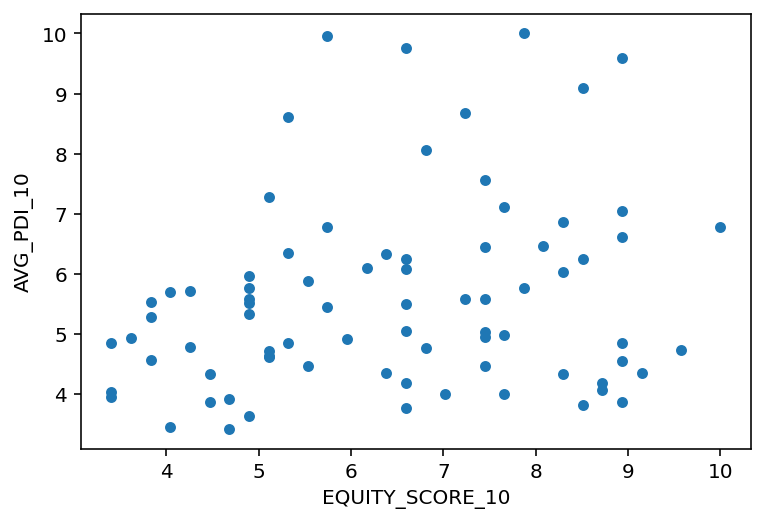

In [131]:
equity_data.plot.scatter(x = "EQUITY_SCORE_10", y = "AVG_PDI_10");

Plotting neighborhoods by "PDI_EQUITY_DIFF."

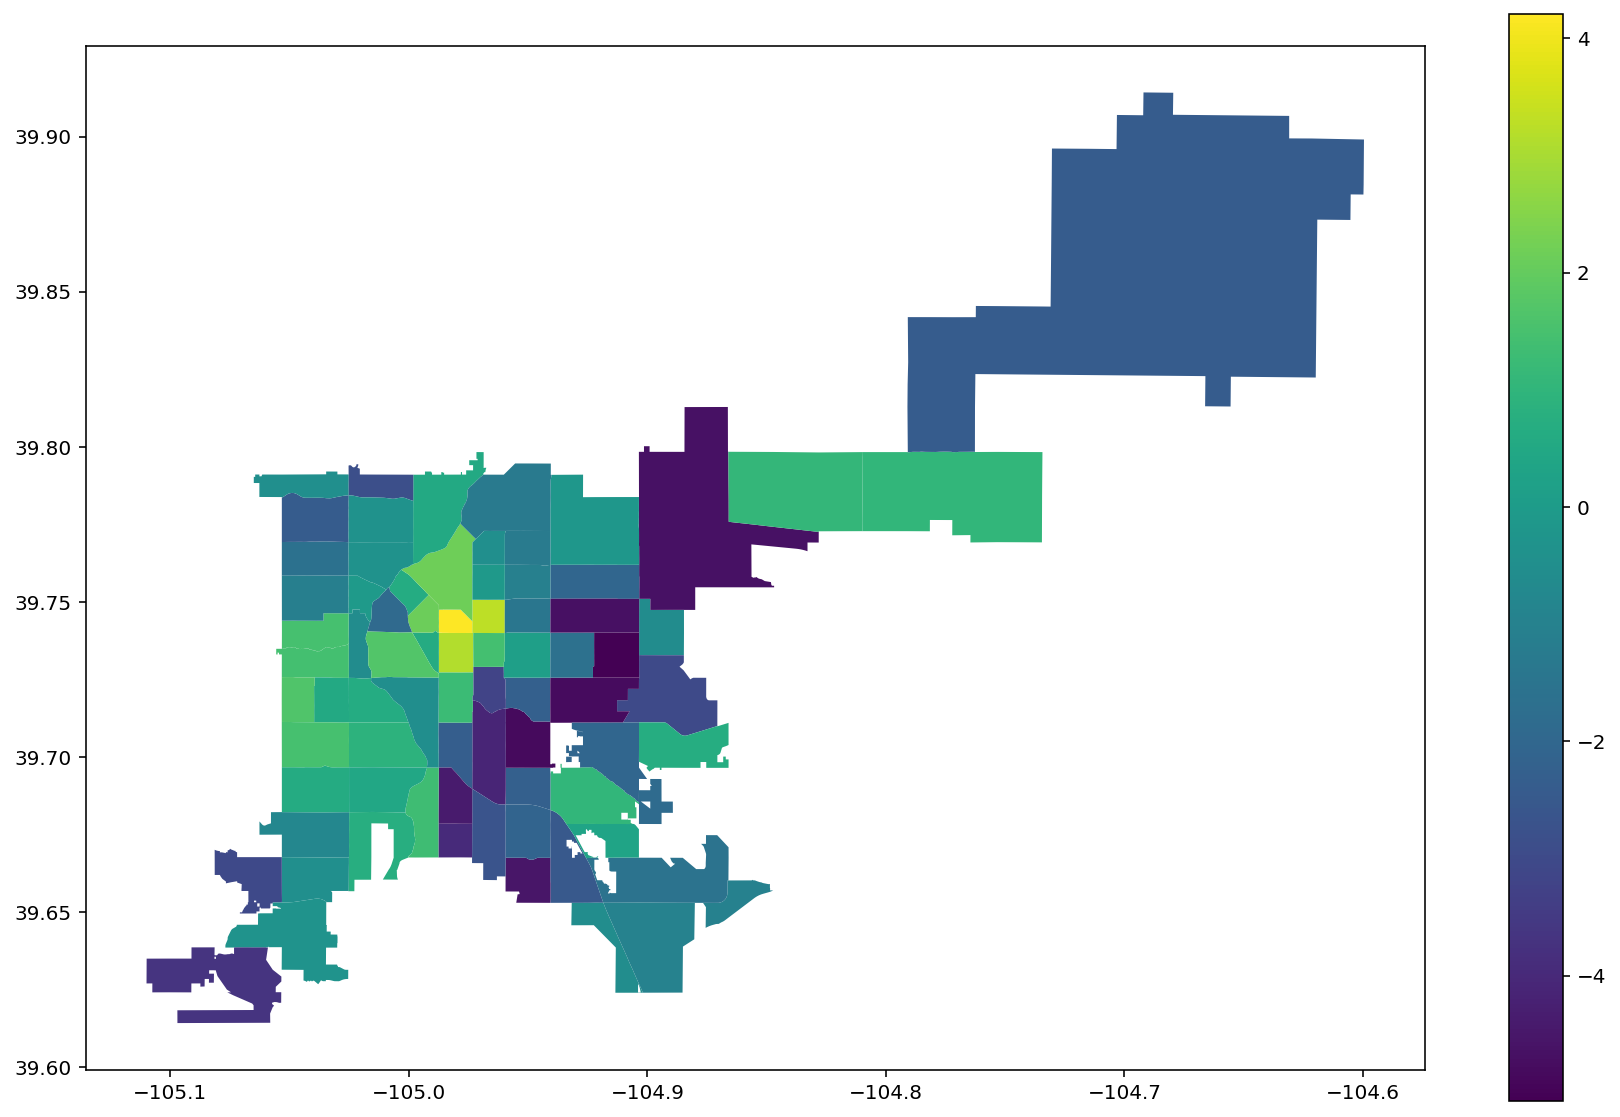

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="PDI_EQUITY_DIFF", ax=ax, legend=True);

Finding and storing top 5 neighborhoods in "nbrhds_of_interest."

In [133]:
nbrhds_of_interest = equity_data.sort_values(by = ["PDI_EQUITY_DIFF"], ascending = False)[0:5]
nbrhds_of_interest.head()

NBRHD_NAME  SOCIOECON_SCORE  ACCESSTOCARE_SCORE  MORBIDITY_SCORE  \
5   North Capitol Hill              3.0                 2.0              2.5   
15      City Park West              2.5                 3.0              2.0   
4         Capitol Hill              4.0                 2.5              4.0   
19         Five Points              2.5                 1.5              3.5   
7                  CBD              2.5                 2.0              4.0   

    MORTALITY_SCORE  BUILTENV_SCORE  OVERALLEQUITY_SCORE  EQUITY_SCORE_10  \
5               1.0             5.0                  2.7         5.744681   
15              1.0             4.0                  2.5         5.319149   
4               1.0             4.0                  3.1         6.595745   
19              1.0             3.5                  2.4         5.106383   
7               5.0             5.0                  3.7         7.872341   

    AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  SHAPE_Area  \
5        8.916667    9.950766         4.206085      0.040371    0.000096   
15       7.714286    8.608940         3.289791      0.048647    0.000146   
4        8.736842    9.750086         3.154342      0.054472    0.000184   
19       6.525000    7.281729         2.175345      0.102129    0.000479   
7        8.960784   10.000000         2.127659      0.042534    0.000117   

                                             geometry  
5   MULTIPOLYGON (((-104.97338 39.74378, -104.9733...  
15  MULTIPOLYGON (((-104.95978 39.73999, -104.9604...  
4   MULTIPOLYGON (((-104.97341 39.74003, -104.9729...  
19  MULTIPOLYGON (((-104.97192 39.77030, -104.9733...  
7   MULTIPOLYGON (((-104.98740 39.74736, -104.9874...

Plotting neighborhoods of interest.

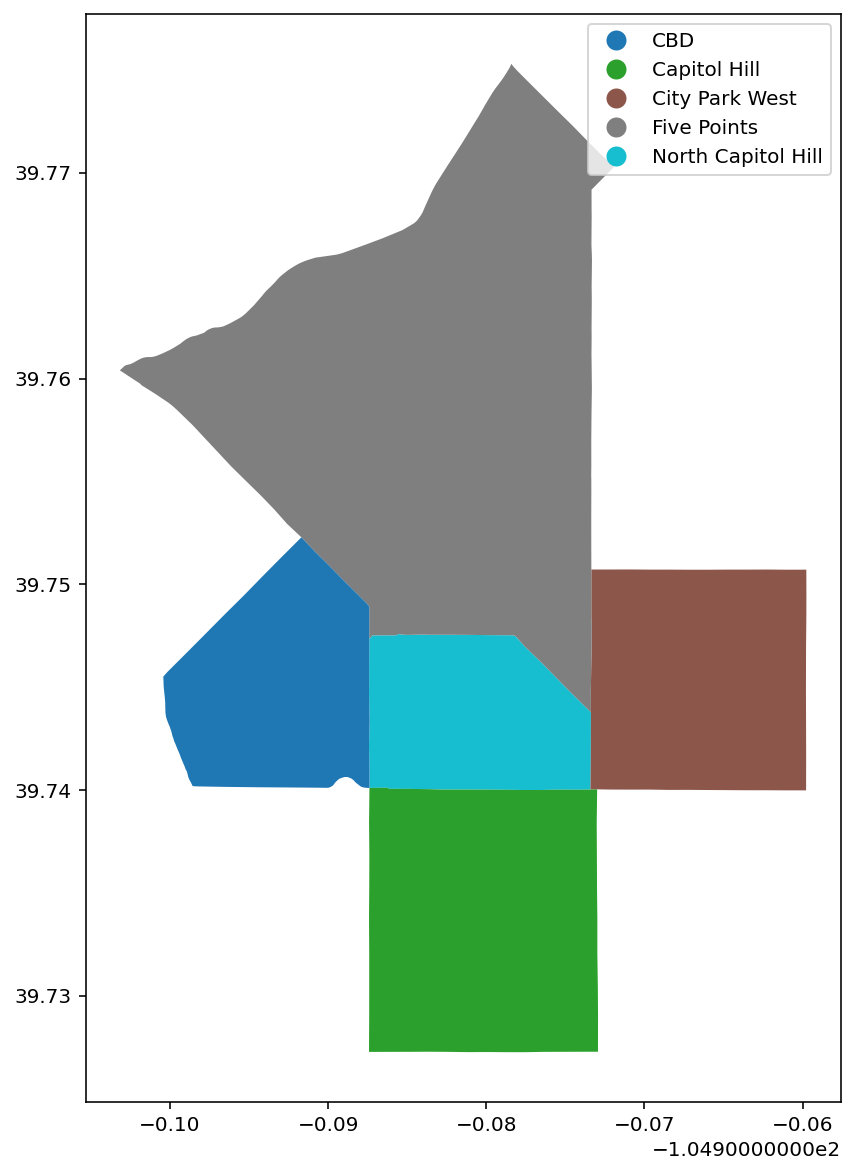

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, legend=True);

# Street Selection

## Crash Data

Storing crash data.

In [135]:
crash_data = gpd.read_file("../data/traffic_accidents.gdb", driver="OpenFileGDB")
crash_data.head()

OBJECTID_1 INCIDENT_ID       OFFENSE_ID OFFENSE_CODE  \
0         1.0  2017100002  201710000254410         5441   
1         2.0  2017100074  201710007454410         5441   
2         3.0  2017100083  201710008354410         5441   
3         4.0  2017100084  201710008454410         5441   
4         5.0  2017100117  201710011754010         5401   

  OFFENSE_CODE_EXTENSION    TOP_TRAFFIC_ACCIDENT_OFFENSE  \
0                      0  TRAF - ACCIDENT                  
1                      0  TRAF - ACCIDENT                  
2                      0  TRAF - ACCIDENT                  
3                      0  TRAF - ACCIDENT                  
4                      0  TRAF - ACCIDENT - HIT & RUN      

                      INCIDENT_ADDRESS      GEO_X      GEO_Y     GEO_LON  ...  \
0   I70 HWYEB / N NORTHFIELD QUEBEC ST  3167637.0  1708927.0 -104.903568  ...   
1                 3200 N BRIGHTON BLVD  3145663.0  1704934.0 -104.981828  ...   
2               I70 HWYEB / I270 HWYWB  3174254.0  1708511.0 -104.880037  ...   
3        W 1ST AVENUE / N VRAIN STREET        NaN        NaN         NaN  ...   
4  S PLATTE RIVER DR / W TENNESSEE AVE  3142747.0  1679702.0 -104.992702  ...   

   TU2_DRIVER_ACTION TU2_DRIVER_HUMANCONTRIBFACTOR TU2_PEDESTRIAN_ACTION  \
0                 00                   NO APPARENT                 OTHER   
1                 00                   NO APPARENT                 OTHER   
2                 00                   NO APPARENT                 OTHER   
3                 00                   NO APPARENT                 OTHER   
4                 00                   NO APPARENT                 OTHER   

  SERIOUSLY_INJURED  FATALITIES  FATALITY_MODE_1 FATALITY_MODE_2  \
0               0.0         0.0            OTHER           OTHER   
1               0.0         0.0            OTHER           OTHER   
2               0.0         0.0            OTHER           OTHER   
3               0.0         0.0            OTHER           OTHER   
4               0.0         0.0            OTHER           OTHER   

  SERIOUSLY_INJURED_MODE_1 SERIOUSLY_INJURED_MODE_2  \
0                    OTHER                    OTHER   
1                    OTHER                    OTHER   
2                    OTHER                    OTHER   
3                    OTHER                    OTHER   
4                    OTHER                    OTHER   

                      geometry  
0  POINT (-104.90357 39.77830)  
1  POINT (-104.98183 39.76771)  
2  POINT (-104.88004 39.77704)  
3                         None  
4  POINT (-104.99270 39.69849)  

[5 rows x 43 columns]

Subsetting crash data by pedestrian-involved, bicyclist-involved, or involving serious injury or death.

In [136]:
crash_data = crash_data[(crash_data["BICYCLE_IND"] > 0) | (crash_data["PEDESTRIAN_IND"] > 0) | (crash_data["SERIOUSLY_INJURED"] > 0) | (crash_data["FATALITIES"] > 0)]
crash_data.head()

OBJECTID_1 INCIDENT_ID       OFFENSE_ID OFFENSE_CODE  \
44        45.0  2017101418  201710141854411         5441   
51        52.0  2017102174  201710217454410         5441   
67        68.0  2017102725  201710272554410         5441   
75        76.0  2017102901  201710290154411         5441   
82        83.0  2017103278  201710327854010         5401   

   OFFENSE_CODE_EXTENSION    TOP_TRAFFIC_ACCIDENT_OFFENSE  \
44                      1  TRAF - ACCIDENT - SBI            
51                      0  TRAF - ACCIDENT                  
67                      0  TRAF - ACCIDENT                  
75                      1  TRAF - ACCIDENT - SBI            
82                      0  TRAF - ACCIDENT - HIT & RUN      

               INCIDENT_ADDRESS      GEO_X      GEO_Y     GEO_LON  ...  \
44       2600 BLOCK S MONACO ST  3165327.0  1669042.0 -104.912704  ...   
51            3550 S KENDALL ST  3122263.0  1662642.0 -105.065788  ...   
67  I70 HWYWB / N BRIGHTON BLVD  3149779.0  1709487.0 -104.967092  ...   
75     4300 BLOCK W FLORIDA AVE  3128406.0  1676323.0 -105.043727  ...   
82           1600 BLOCK 17TH ST  3140799.0  1699264.0 -104.999242  ...   

    TU2_DRIVER_ACTION TU2_DRIVER_HUMANCONTRIBFACTOR  \
44              OTHER                         OTHER   
51                 00                   NO APPARENT   
67                 00                   NO APPARENT   
75              OTHER                         OTHER   
82                 00                   NO APPARENT   

          TU2_PEDESTRIAN_ACTION SERIOUSLY_INJURED  FATALITIES  \
44                        OTHER               1.0         0.0   
51                        OTHER               0.0         0.0   
67                        OTHER               1.0         0.0   
75  CROSS/ENTER AT INTERSECTION               0.0         0.0   
82                        OTHER               0.0         0.0   

    FATALITY_MODE_1 FATALITY_MODE_2 SERIOUSLY_INJURED_MODE_1  \
44            OTHER           OTHER               PEDESTRIAN   
51            OTHER           OTHER                    OTHER   
67            OTHER           OTHER        PASSENGER CAR/VAN   
75            OTHER           OTHER                    OTHER   
82            OTHER           OTHER                    OTHER   

   SERIOUSLY_INJURED_MODE_2                     geometry  
44                    OTHER  POINT (-104.91270 39.66885)  
51                    OTHER  POINT (-105.06579 39.65195)  
67                    OTHER  POINT (-104.96709 39.78014)  
75                    OTHER  POINT (-105.04373 39.68942)  
82                    OTHER  POINT (-104.99924 39.75222)  

[5 rows x 43 columns]

Subsetting "crash_data" by intersecting with "nbrhds_of_interest."

In [137]:
crash_data = crash_data.sjoin(nbrhds_of_interest)
crash_data.head()

OBJECTID_1 INCIDENT_ID       OFFENSE_ID OFFENSE_CODE  \
756        757.0  2017129310  201712931054411         5441   
1401      1402.0  2017154488  201715448854411         5441   
1607      1608.0  2017161884  201716188454410         5441   
1805      1806.0  2017169902  201716990254411         5441   
2305      2306.0  2017185042  201718504254410         5441   

     OFFENSE_CODE_EXTENSION    TOP_TRAFFIC_ACCIDENT_OFFENSE  \
756                       1  TRAF - ACCIDENT - SBI            
1401                      1  TRAF - ACCIDENT - SBI            
1607                      0  TRAF - ACCIDENT                  
1805                      1  TRAF - ACCIDENT - SBI            
2305                      0  TRAF - ACCIDENT                  

                  INCIDENT_ADDRESS      GEO_X      GEO_Y     GEO_LON  ...  \
756   E 14TH AVE / N WASHINGTON ST  3146596.0  1694270.0 -104.978727  ...   
1401        700 BLOCK N SHERMAN ST  3144911.0  1690528.0 -104.984794  ...   
1607      E 14TH AVE / N CORONA ST  3147888.0  1694278.0 -104.974133  ...   
1805     E 10TH AVE / N LINCOLN ST  3144528.0  1691934.0 -104.986127  ...   
2305    1200 BLOCK N WASHINGTON ST  3146630.0  1693395.0 -104.978624  ...   

      MORBIDITY_SCORE MORTALITY_SCORE BUILTENV_SCORE OVERALLEQUITY_SCORE  \
756               4.0             1.0            4.0                 3.1   
1401              4.0             1.0            4.0                 3.1   
1607              4.0             1.0            4.0                 3.1   
1805              4.0             1.0            4.0                 3.1   
2305              4.0             1.0            4.0                 3.1   

      EQUITY_SCORE_10  AVG_PDI_SCORE AVG_PDI_10 PDI_EQUITY_DIFF SHAPE_Length  \
756          6.595745       8.736842   9.750086        3.154342     0.054472   
1401         6.595745       8.736842   9.750086        3.154342     0.054472   
1607         6.595745       8.736842   9.750086        3.154342     0.054472   
1805         6.595745       8.736842   9.750086        3.154342     0.054472   
2305         6.595745       8.736842   9.750086        3.154342     0.054472   

     SHAPE_Area  
756    0.000184  
1401   0.000184  
1607   0.000184  
1805   0.000184  
2305   0.000184  

[5 rows x 57 columns]

Plotting crashes within neighborhoods of interest.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


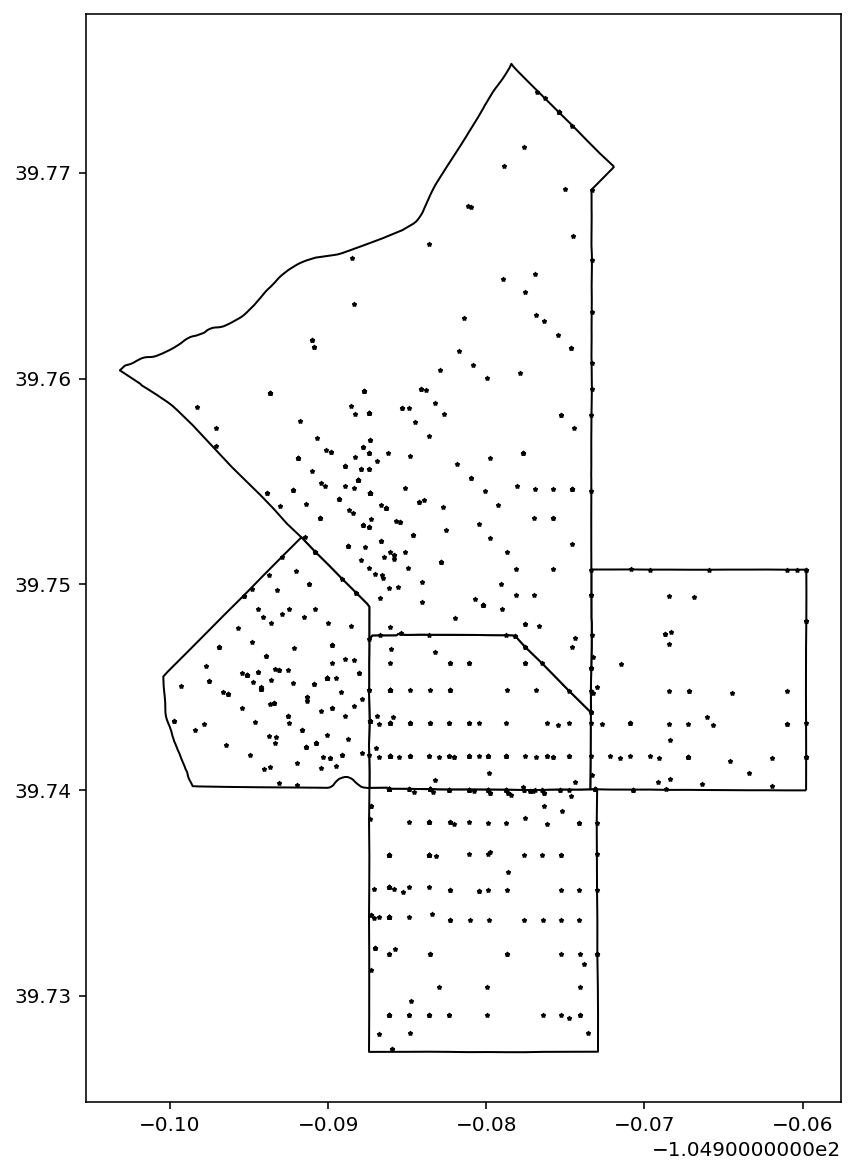

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
crash_data.plot(ax = base, marker = "*", color = "black", markersize = 3);

## Key Destinations

### Park Data

Storing park data.

In [139]:
park_data = gpd.read_file("../data/parks.gdb", driver="OpenFileGDB")
park_data.head()

LOCATION                        FORMAL_NAME  \
0                            Verbena                       Verbena Park   
1                   Legault Mountain            Legault Mountain Tracts   
2                         Hobbs Peak                   Hobbs Peak Tract   
3                   City of Takayama              City of Takayama Park   
4  Highline Canal (Parker to Havana)  Highline Canal (Parker to Havana)   

  LOC_CODE           PARK_TYPE    PARK_CLASS   GIS_ACRES    DESIGNATED  \
0      L18                Park  Neighborhood    7.185635           Yes   
1      M30  Conservation Tract      Mountain  134.790235           Yes   
2      M29  Conservation Tract      Mountain   38.849537           Yes   
3      331                Park        Linear    6.060320           Yes   
4      661                Park        Linear   28.792370  Not Eligible   

      FIRST_AQ_DATE MASTER_PLAN MAINT_DIST  ...   LONGITUDE MARKETING_CODE  \
0              1969        None         NE  ... -104.891271             PK   
1              1924        2008         MP  ... -105.245073           None   
2              1925        2008         MP  ... -105.302888           None   
3              1966        None          E  ... -104.943746             PK   
4  N/A - DW (1980s)         N/A         NE  ... -104.884899           None   

                                          FACILITIES  \
0  Picnic Shelter, Picnic Tables, Benches, Playgr...   
1               Scenic View Shed, Natural Open Space   
2               Scenic View Shed, Natural Open Space   
3  Benches, Bike/Pedestrian Path, Cherry Creek Trail   
4  Bike/Pedestrian Path, High Line Canal Trail, O...   

                             DIAGRAM             PHOTO PARCEL_MATCH  \
0           ParkArt_Verbena Park.pdf   verbenapark.jpg          Yes   
1                                      no_imagerec.gif         None   
2                                      no_imagerec.gif         None   
3  ParkArt_City of Takayama Park.pdf  takayamapark.jpg           No   
4         ParkArt_Highline Canal.pdf   no_imagerec.gif          Yes   

                      BND_QC SHAPE_Length SHAPE_Area  \
0  2015-09-09T00:00:00+00:00     0.007571   0.000003   
1  2010-05-14T00:00:00+00:00     0.053131   0.000057   
2  2010-05-21T00:00:00+00:00     0.016372   0.000016   
3  2009-09-30T00:00:00+00:00     0.016074   0.000003   
4  2009-06-08T00:00:00+00:00     0.085017   0.000012   

                                            geometry  
0  MULTIPOLYGON (((-104.89070 39.73294, -104.8918...  
1  MULTIPOLYGON (((-105.24317 39.53059, -105.2431...  
2  MULTIPOLYGON (((-105.30059 39.59120, -105.3012...  
3  MULTIPOLYGON (((-104.94715 39.71108, -104.9464...  
4  MULTIPOLYGON (((-104.89017 39.70461, -104.8901...  

[5 rows x 30 columns]

Subsetting park data by intersecting with neighborhoods of interest.

In [140]:
park_data = park_data.sjoin(nbrhds_of_interest)
park_data.head()

LOCATION                 FORMAL_NAME LOC_CODE PARK_TYPE  \
27          MacIntosh  MacIntosh (Kenneth M) Park      236      Park   
128           Skyline                Skyline Park      332      Park   
191         Sculpture              Sculpture Park      340      Park   
204  Pioneer Monument       Pioneer Monument Park      233      Park   
42          Governors              Governors Park      316      Park   

       PARK_CLASS  GIS_ACRES  DESIGNATED FIRST_AQ_DATE MASTER_PLAN MAINT_DIST  \
27         Pocket   0.325579         Yes          1982        None   Downtown   
128   Special Use   2.560731  Yes - 1994          1973        2002   Downtown   
191   Special Use   2.530312  Yes - 1981         1960s        None   Downtown   
204        Pocket   0.297578  Yes - 1956          1906        None   Downtown   
42   Neighborhood   1.976757         Yes          1966        None          E   

     ... MORBIDITY_SCORE MORTALITY_SCORE BUILTENV_SCORE  OVERALLEQUITY_SCORE  \
27   ...             4.0             5.0            5.0                  3.7   
128  ...             4.0             5.0            5.0                  3.7   
191  ...             4.0             5.0            5.0                  3.7   
204  ...             4.0             5.0            5.0                  3.7   
42   ...             4.0             1.0            4.0                  3.1   

    EQUITY_SCORE_10 AVG_PDI_SCORE AVG_PDI_10 PDI_EQUITY_DIFF  \
27         7.872341      8.960784  10.000000        2.127659   
128        7.872341      8.960784  10.000000        2.127659   
191        7.872341      8.960784  10.000000        2.127659   
204        7.872341      8.960784  10.000000        2.127659   
42         6.595745      8.736842   9.750086        3.154342   

    SHAPE_Length_right  SHAPE_Area_right  
27            0.042534          0.000117  
128           0.042534          0.000117  
191           0.042534          0.000117  
204           0.042534          0.000117  
42            0.054472          0.000184  

[5 rows x 44 columns]

Plotting parks within neighborhoods of interest.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


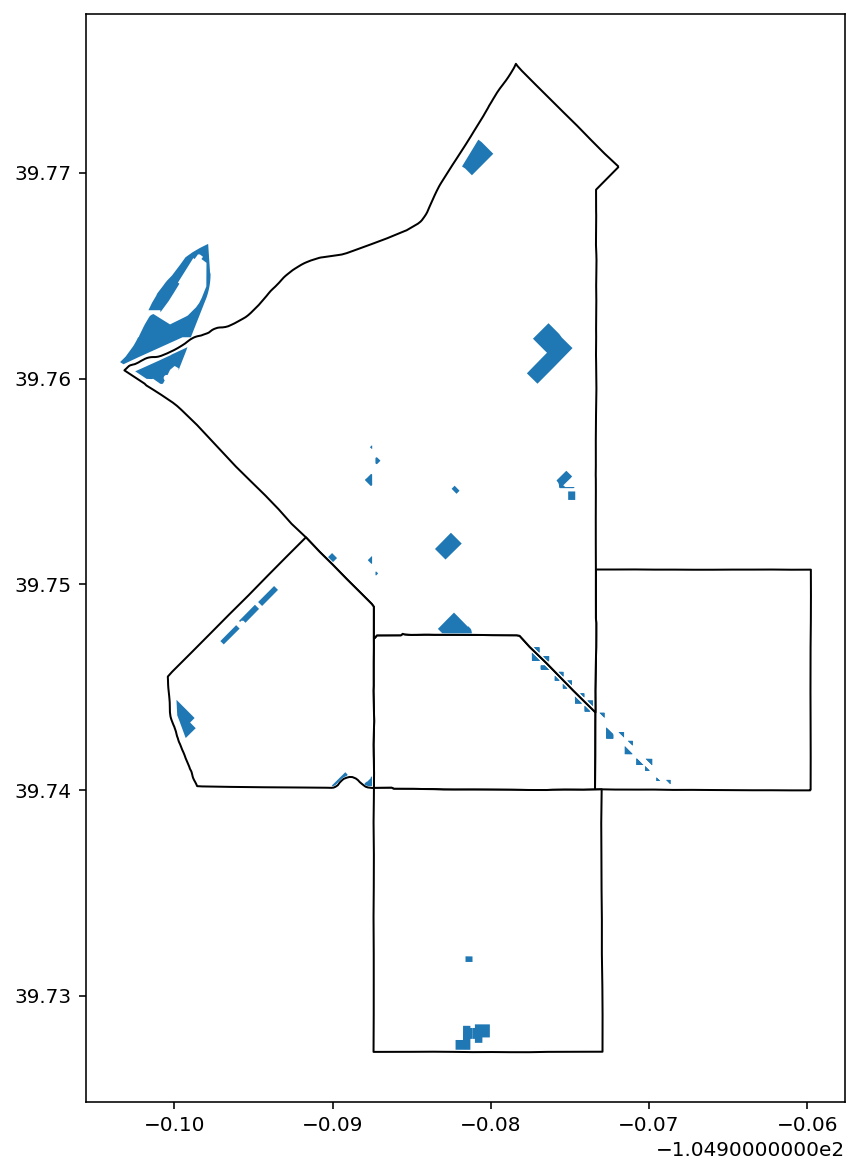

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
park_data.plot(ax = base);

### School Data

Storing school data.

In [142]:
school_data = gpd.read_file("../data/schools/school_point.shp")
school_data.head()

amenity                                    name   ele addr_house addr_postc  \
0  school             Abraham Lincoln High School  1648       None       None   
1  school             Academia Ana Marie Sandoval  1617       3655      80211   
2  school   Academy of Urban Learning High School  None       2417      80211   
3  school  Ace Community Challenge Charter School  1598        948      80204   
4  school                       All Saints School  1649       None       None   

         addr_stree addr_city addr_state phone website  wikidata old_name  \
0              None      None       None  None    None  Q4669022     None   
1    Wyandot Street    Denver         CO  None    None      None     None   
2  West 29th Avenue    Denver         CO  None    None      None     None   
3    Santa Fe Drive    Denver         CO  None    None      None     None   
4              None      None       None  None    None      None     None   

  alt_name addr_unit addr_hou_1 email   fax operator opening_ho  \
0     None      None       None  None  None     None       None   
1     None      None       None  None  None     None       None   
2     None      None       None  None  None     None       None   
3     None      None       None  None  None     None       None   
4     None      None       None  None  None     None       None   

                      geometry  
0  POINT (-105.02693 39.67665)  
1  POINT (-105.01543 39.76713)  
2  POINT (-105.01689 39.75869)  
3  POINT (-104.99849 39.73150)  
4  POINT (-105.02637 39.67193)

Subsetting schools data by intersecting with neighborhoods of interest.

In [143]:
school_data = school_data.sjoin(nbrhds_of_interest)
school_data.head()

amenity                                               name   ele  \
46   school                                  Dora Moore School  1619   
101  school                                Morey Middle School  1613   
50   school                         Emily Griffith High School  None   
57   school                    Gilpin Montessori Public School  1592   
95   school  Mile High Montessori Edna Oliver Early Learnin...  None   

    addr_house addr_postc         addr_stree addr_city addr_state  \
46         846      80218      Corona Street    Denver         CO   
101        840      80218   East 14th Avenue    Denver         CO   
50        1860      80203     Lincoln Street    Denver         CO   
57        2949      80205  California Street    Denver         CO   
95        2851      80205      Tremont Place    Denver         CO   

            phone website  ... MORBIDITY_SCORE MORTALITY_SCORE BUILTENV_SCORE  \
46   720-424-5300    None  ...             4.0             1.0            4.0   
101          None    None  ...             4.0             1.0            4.0   
50           None    None  ...             2.5             1.0            5.0   
57   720-424-7140    None  ...             3.5             1.0            3.5   
95           None    None  ...             3.5             1.0            3.5   

    OVERALLEQUITY_SCORE EQUITY_SCORE_10 AVG_PDI_SCORE AVG_PDI_10  \
46                  3.1        6.595745      8.736842   9.750086   
101                 3.1        6.595745      8.736842   9.750086   
50                  2.7        5.744681      8.916667   9.950766   
57                  2.4        5.106383      6.525000   7.281729   
95                  2.4        5.106383      6.525000   7.281729   

    PDI_EQUITY_DIFF SHAPE_Length SHAPE_Area  
46         3.154342     0.054472   0.000184  
101        3.154342     0.054472   0.000184  
50         4.206085     0.040371   0.000096  
57         2.175345     0.102129   0.000479  
95         2.175345     0.102129   0.000479  

[5 rows x 34 columns]

Plotting schools within neighborhoods of interest.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


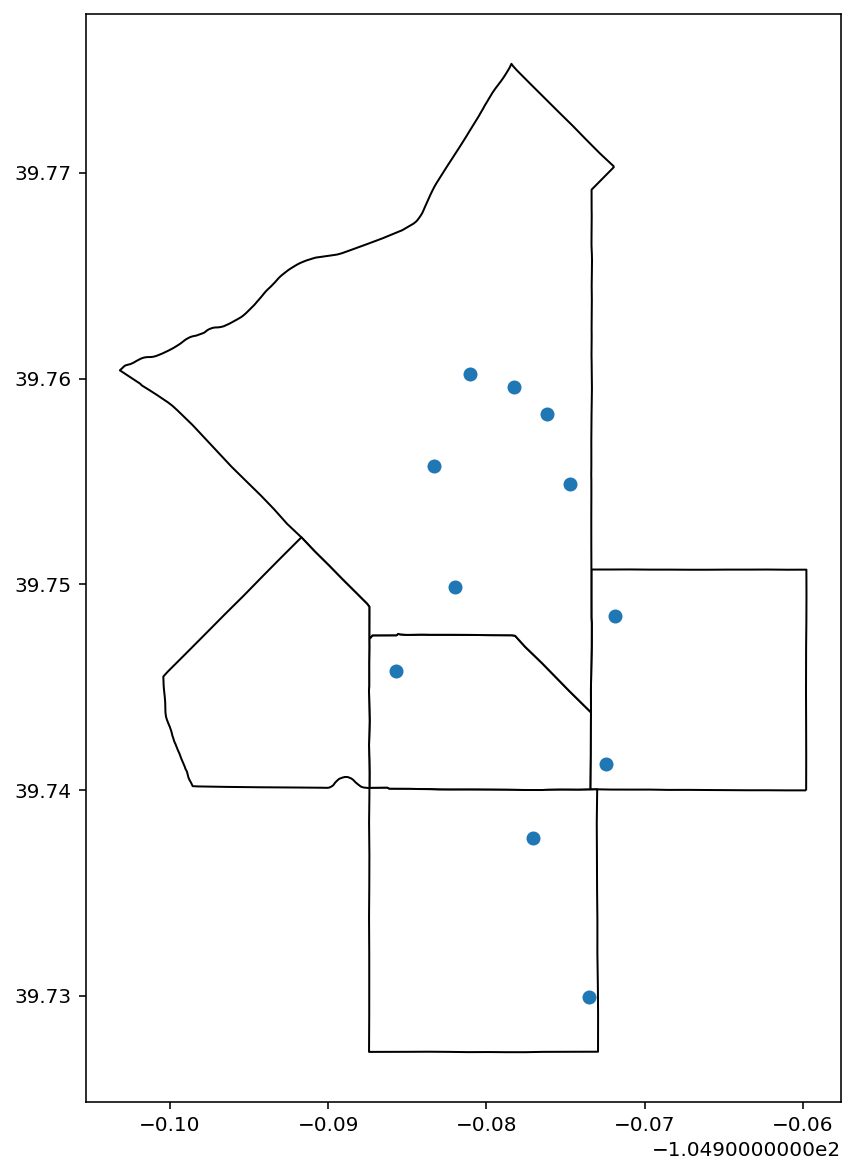

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
school_data.plot(ax = base);

### Transit Stops

#### Bus Stop Data

Storing bus stop data.

In [145]:
bus_data = gpd.read_file("../data/busstops/RTD_GIS_Current_Runboard.shp")
bus_data.head()

OBJECTID   BSID         LNG        LAT       X_COORD       Y_COORD  STATUS  \
0   3367927  13768 -105.025279  39.729654  3.133521e+06  1.691005e+06  active   
1   3367928  23955 -104.994238  39.759506  3.142191e+06  1.701926e+06  active   
2   3367929  17398 -104.959690  39.759724  3.151904e+06  1.702061e+06  active   
3   3367930  11069 -104.975069  39.772599  3.147553e+06  1.706726e+06  active   
4   3367931  11084 -105.115058  39.718918  3.108286e+06  1.686975e+06  active   

                 ROUTES                    STOPNAME DIR  ...      COMMENTS  \
0                31, 30    Federal Blvd & W 8th Ave   S  ...      AUG 2019   
1  120X, 38, LX, FF, LD  Park Ave West & Wewatta St  SE  ...  DELGANY RAMP   
2                    24          York St & 30th Ave   N  ...          None   
3                    12     38th St & Brighton Blvd  SE  ...          None   
4                    GS    3rd St & Main Ave {1304}  NW  ...          None   

       ON_STREET      AT_STREET  BETWEEN__1  STATION_ID HUBABBR HUBNAME  \
0   Federal Blvd       W 8th Av        None         NaN    None    None   
1  Park Ave West     Wewatta St        None         NaN    None    None   
2        York St     E 30th Ave        None         NaN    None    None   
3        38th St  Brighton Blvd        None         NaN    None    None   
4         3rd St     W Main Ave        None         NaN    None    None   

  SBOARDS                                   STOPNAME_B  \
0       0    Federal Blvd & W 8th Ave (Stop No. 13768)   
1       0  Park Ave West & Wewatta St (Stop No. 23955)   
2       0          York St & 30th Ave (Stop No. 17398)   
3       0     38th St & Brighton Blvd (Stop No. 11069)   
4       0    3rd St & Main Ave {1304} (Stop No. 11084)   

                      geometry  
0  POINT (-105.02529 39.72966)  
1  POINT (-104.99425 39.75951)  
2  POINT (-104.95970 39.75973)  
3  POINT (-104.97508 39.77261)  
4  POINT (-105.11507 39.71892)  

[5 rows x 37 columns]

Subsetting bus stop data within neighborhoods of interest.

In [146]:
bus_data = bus_data.sjoin(nbrhds_of_interest)
bus_data.head()

OBJECTID   BSID         LNG        LAT       X_COORD       Y_COORD  \
1     3367928  23955 -104.994238  39.759506  3.142191e+06  1.701926e+06   
3     3367930  11069 -104.975069  39.772599  3.147553e+06  1.706726e+06   
175   3368102  25925 -104.996797  39.756907  3.141477e+06  1.700975e+06   
198   3368125  16662 -104.981914  39.754388  3.145667e+06  1.700081e+06   
213   3368140  23956 -104.993902  39.759690  3.142285e+06  1.701994e+06   

     STATUS                ROUTES                    STOPNAME DIR  ...  \
1    active  120X, 38, LX, FF, LD  Park Ave West & Wewatta St  SE  ...   
3    active                    12     38th St & Brighton Blvd  SE  ...   
175  active          120X, LX, LD        Wewatta St & 21st St  SW  ...   
198  active                    43          Stout St & 25th St  NE  ...   
213  active  120X, 38, FF, LX, LD     Park Ave W & Delgany St  NW  ...   

     MORBIDITY_SCORE MORTALITY_SCORE  BUILTENV_SCORE  OVERALLEQUITY_SCORE  \
1                3.5             1.0             3.5                  2.4   
3                3.5             1.0             3.5                  2.4   
175              3.5             1.0             3.5                  2.4   
198              3.5             1.0             3.5                  2.4   
213              3.5             1.0             3.5                  2.4   

     EQUITY_SCORE_10 AVG_PDI_SCORE AVG_PDI_10 PDI_EQUITY_DIFF SHAPE_Length  \
1           5.106383         6.525   7.281729        2.175345     0.102129   
3           5.106383         6.525   7.281729        2.175345     0.102129   
175         5.106383         6.525   7.281729        2.175345     0.102129   
198         5.106383         6.525   7.281729        2.175345     0.102129   
213         5.106383         6.525   7.281729        2.175345     0.102129   

     SHAPE_Area  
1      0.000479  
3      0.000479  
175    0.000479  
198    0.000479  
213    0.000479  

[5 rows x 51 columns]

Plotting bus stops within neighborhoods of interest.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


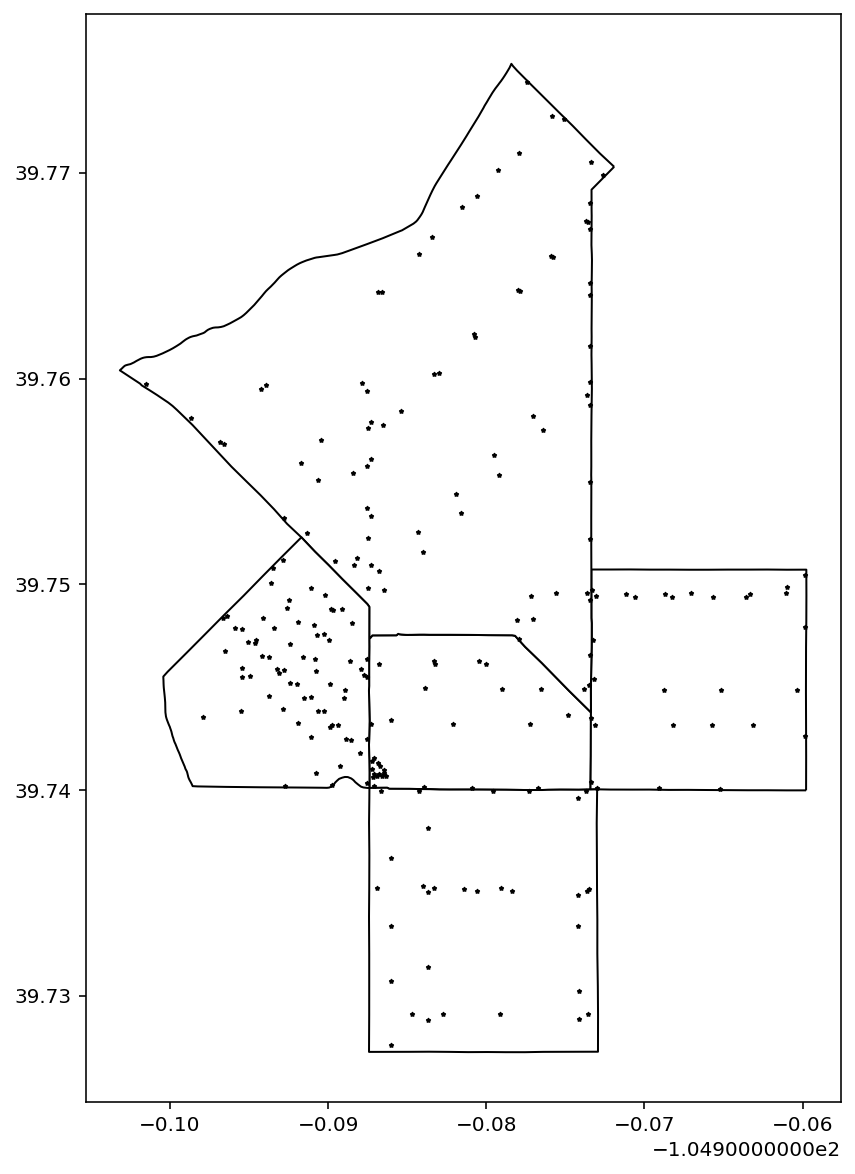

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
bus_data.plot(ax = base, marker = "*", color = "black", markersize = 3);

#### Lightrail Stop Data

Storing lightrail stop data.

In [148]:
lightrail_data = gpd.read_file("../data/lightrailstations/RTD_GIS_Current_Runboard.shp")
lightrail_data.head()

OBJECTID  PID                             NAME    LOCAL_RTS EXPRESS_RT  \
0        80   64      Littleton / Mineral Station         402L       None   
1        81   63     Littleton / Downtown Station  29-36-59-66       None   
2        82   65  Oxford-City of Sheridan Station           51       None   
3        83    1                  Alameda Station     1-3-4-52       None   
4        84   71     18th St / California Station         None       None   

  LIMITED_RT REGIONAL_R SKYRIDE_RT SPECIAL_RT             ADDRESS  ...  \
0       None       None       None          D  3203 W Mineral Ave  ...   
1       None       None       None          D    5777 S Prince St  ...   
2       None       None       None          D  4101 Windermere St  ...   
3       None       None       None      D-E-H   499 S Cherokee St  ...   
4       None       None       None      D-H-L  1776 California St  ...   

   ZIPCODE                                      PARCEL_ID_      DIAGRAM  \
0    80120                                    Stop#: 24896  BroncosRide   
1    80120  Stop#: 25438 (South)<br />Stop#: 24894 (North)  BroncosRide   
2    80110  Stop#: 25437 (South)<br />Stop#: 24892 (North)  BroncosRide   
3    80223  Stop#: 23060 (South)<br />Stop#: 23042 (North)  BroncosRide   
4    80202                                    Stop#: 23047         None   

                         LOCATION RAIL_LINE  STOPID           VMAP  CNRS  \
0        S Santa Fe & Mineral Ave         D   33716   South Jeffco  SJFX   
1  SE Corner of Alamo & Prince St         D   33715   South Jeffco  SJFX   
2               Santa Fe & Oxford         D   33726           None  None   
3         Cherokee St & Alaska Pl     D-E-H   33704  Platte Valley  PLFX   
4            18th St & California     D-H-L   34116           None  None   

                                          INFO_REPOR  \
0                                               None   
1  261 spots at station, 100 spots at S. Powers o...   
2                                               None   
3                                               None   
4                                               None   

                      geometry  
0  POINT (-105.02503 39.58009)  
1  POINT (-105.01488 39.61197)  
2  POINT (-105.00482 39.64290)  
3  POINT (-104.99317 39.70868)  
4  POINT (-104.99029 39.74660)  

[5 rows x 30 columns]

Subsetting lightrail stops within neighborhoods of interest.

In [149]:
lightrail_data = lightrail_data.sjoin(nbrhds_of_interest)
lightrail_data.head()

OBJECTID  PID                                  NAME LOCAL_RTS EXPRESS_RT  \
4         84   71          18th St / California Station      None       None   
9         89   72               18th St / Stout Station      None       None   
48       128   69          16th St / California Station      MALL       None   
54       134   70               16th St / Stout Station      MALL       None   
57       137   67  Theatre District / Convention Center      None       None   

   LIMITED_RT REGIONAL_R SKYRIDE_RT SPECIAL_RT             ADDRESS  ...  \
4        None       None       None      D-H-L  1776 California St  ...   
9        None       None       None      D-H-L       1816 Stout St  ...   
48       None       None       None      D-H-L  1516 California St  ...   
54       None       None       None      D-H-L       1617 Stout St  ...   
57       None       None       None        D-H       1325 Stout St  ...   

    MORBIDITY_SCORE  MORTALITY_SCORE  BUILTENV_SCORE OVERALLEQUITY_SCORE  \
4               4.0              5.0             5.0                 3.7   
9               4.0              5.0             5.0                 3.7   
48              4.0              5.0             5.0                 3.7   
54              4.0              5.0             5.0                 3.7   
57              4.0              5.0             5.0                 3.7   

   EQUITY_SCORE_10  AVG_PDI_SCORE AVG_PDI_10 PDI_EQUITY_DIFF SHAPE_Length  \
4         7.872341       8.960784       10.0        2.127659     0.042534   
9         7.872341       8.960784       10.0        2.127659     0.042534   
48        7.872341       8.960784       10.0        2.127659     0.042534   
54        7.872341       8.960784       10.0        2.127659     0.042534   
57        7.872341       8.960784       10.0        2.127659     0.042534   

   SHAPE_Area  
4    0.000117  
9    0.000117  
48   0.000117  
54   0.000117  
57   0.000117  

[5 rows x 44 columns]

Plotting lightrail stops within neighborhoods of interest.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


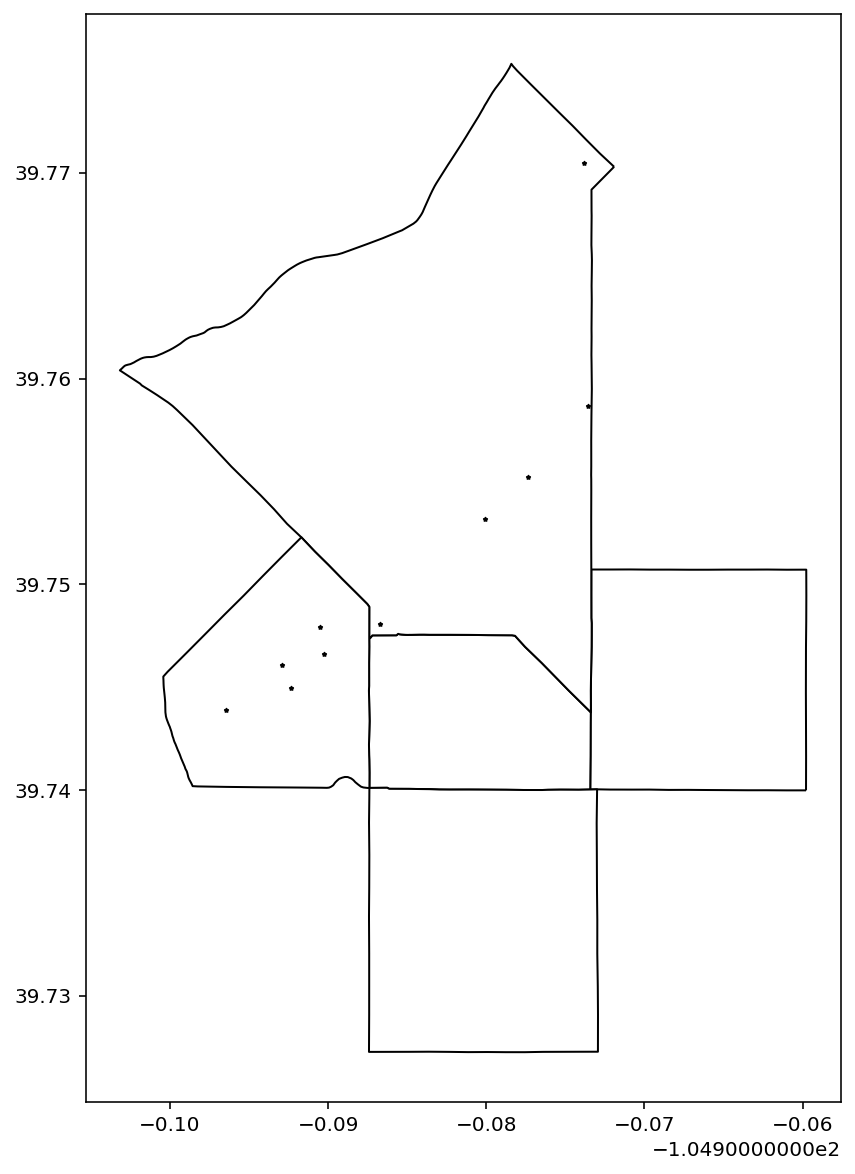

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
lightrail_data.plot(ax = base, marker = "*", color = "black", markersize = 3);

## Street Data

Storing street data.

In [151]:
street_data = ox.graph.graph_from_polygon(unary_union(nbrhds_of_interest.geometry.values), network_type="drive")

Plotting streets within neighborhoods of interest with key destinations and crashes.

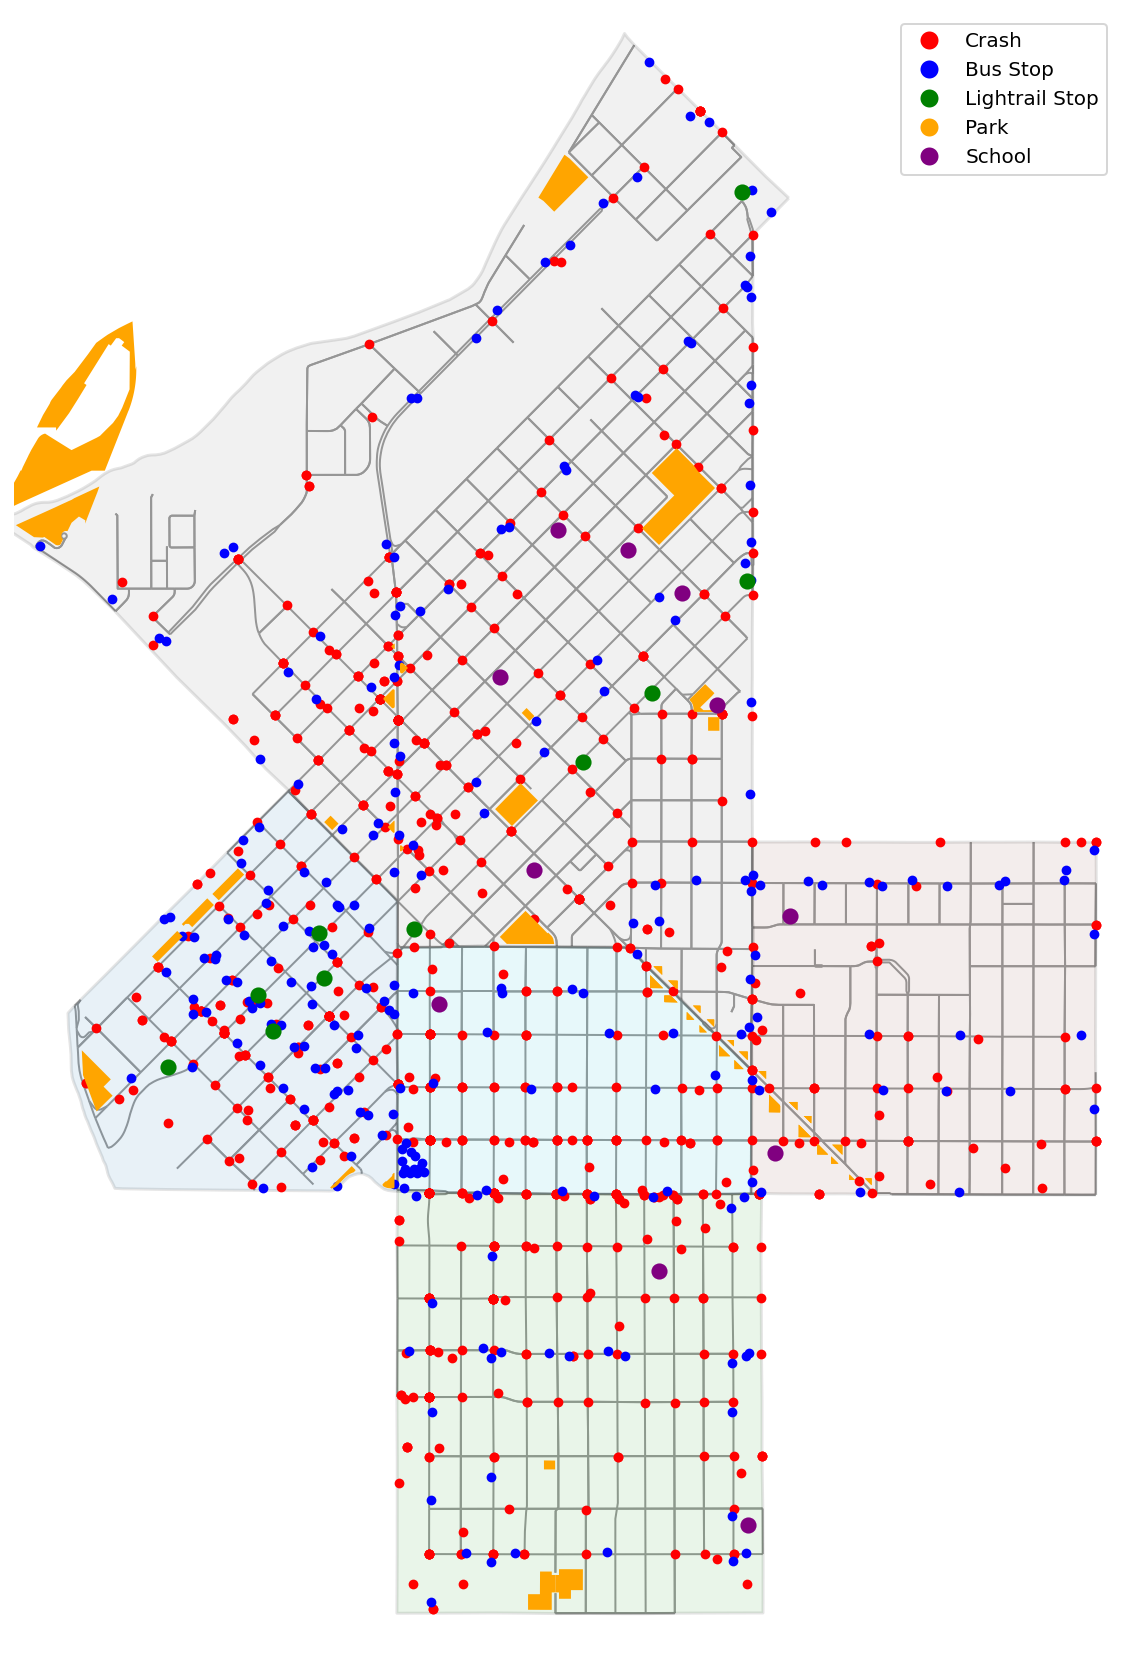

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15), facecolor="white")

legend = [line.Line2D([0],[0],marker='o',color='w',label='Crash', markerfacecolor='red', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Bus Stop', markerfacecolor='blue', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Lightrail Stop', markerfacecolor='green', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Park', markerfacecolor='orange', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='School', markerfacecolor='purple', markersize=10)]
ax.legend(handles=legend)

fig, base = ox.plot_graph(street_data, node_alpha=0, show=False, bgcolor="white", ax=ax)
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=base, alpha=0.1, edgecolor="black", linewidth=1.5)
crash_data.plot(ax = base, marker = "o", color = "red", markersize = 15)
bus_data.plot(ax = base, marker = "o", color = "blue", markersize = 15)
lightrail_data.plot(ax = base, marker = "o", color = "green", markersize = 50)
park_data.plot(ax = base, color = "orange")
school_data.plot(ax = base, color = "purple", markersize = 50);

Creating 1/4 mile (400 m) buffer around street data.

In [153]:
street_buffers = ox.utils_graph.graph_to_gdfs(street_data, edges=True, nodes=False)\
    .to_crs(epsg=util.CONFIG.local_crs)
street_buffers["geometry"] = street_buffers["geometry"].buffer(400)
street_buffers = street_buffers.to_crs(epsg=util.CONFIG.base_crs)
street_buffers.head()

osmid lanes  \
u         v          key                                           
176064699 176109088  0    [321325005, 16988019, 628408629]     2   
176066218 176088631  0                           596718939     4   
          176102962  0                           446229334     2   
          176095814  0                           628159785     4   
176070171 1160471898 0                           100397027     7   

                                         name      highway  oneway   length  \
u         v          key                                                      
176064699 176109088  0    Little Raven Street  residential   False  134.648   
176066218 176088631  0            York Street    secondary   False  141.163   
          176102962  0       East 21st Avenue     tertiary   False  104.397   
          176095814  0            York Street    secondary   False  138.675   
176070171 1160471898 0     East Colfax Avenue      primary   False   43.128   

                                                                   geometry  \
u         v          key                                                      
176064699 176109088  0    POLYGON ((-105.00560 39.76169, -105.00558 39.7...   
176066218 176088631  0    POLYGON ((-104.95513 39.74693, -104.95515 39.7...   
          176102962  0    POLYGON ((-104.95988 39.74461, -104.95988 39.7...   
          176095814  0    POLYGON ((-104.96444 39.74938, -104.96444 39.7...   
176070171 1160471898 0    POLYGON ((-104.98499 39.73646, -104.98537 39.7...   

                         maxspeed                    ref access bridge tunnel  
u         v          key                                                       
176064699 176109088  0        NaN                    NaN    NaN    NaN    NaN  
176066218 176088631  0     30 mph                    NaN    NaN    NaN    NaN  
          176102962  0        NaN                    NaN    NaN    NaN    NaN  
          176095814  0     30 mph                    NaN    NaN    NaN    NaN  
176070171 1160471898 0     30 mph  I 70 Bus;US 40;US 287    NaN    NaN    NaN

Plotting streets with buffers.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


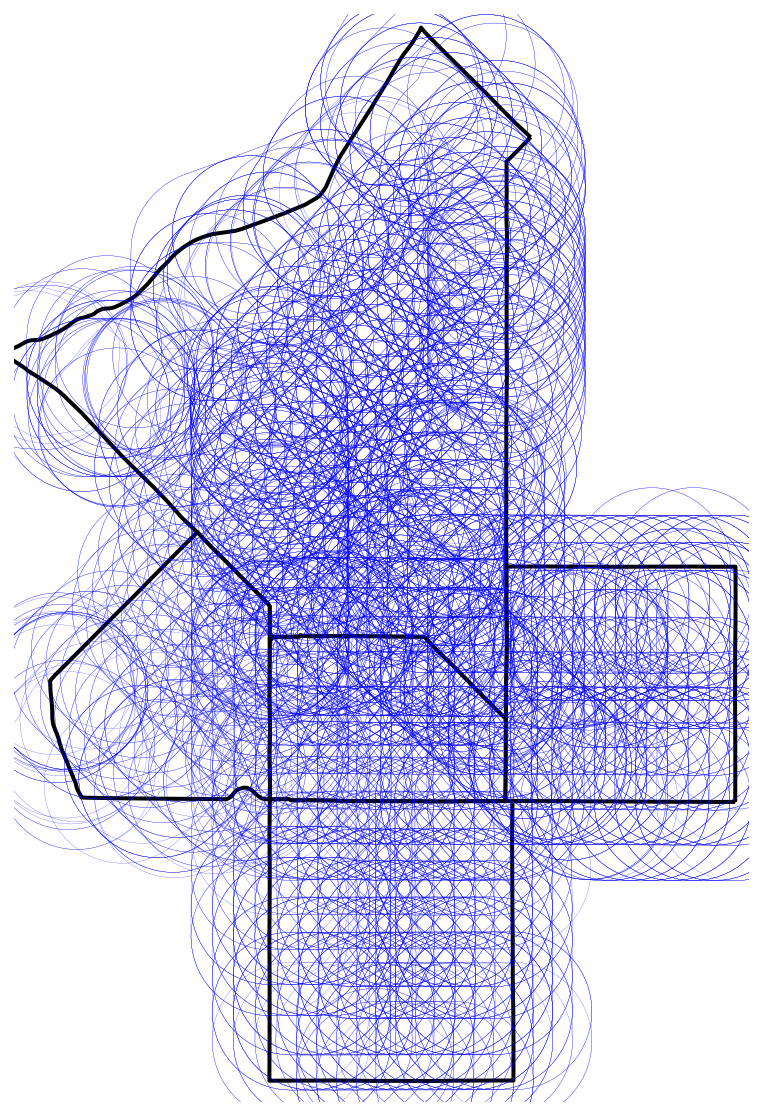

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
fig, base = ox.plot_graph(street_data, node_alpha=0, show=False, bgcolor="white", ax=ax)
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=base, color="white", edgecolor="black", linewidth=2)
#street_data.plot(ax = base, color = "black", linewidth = 1)
street_buffers.plot(ax = base, color = "none", edgecolor = "blue", linewidth = 0.1);

In [155]:
street_edges = ox.utils_graph.graph_to_gdfs(street_data, edges=True, nodes=False)

## Crashes and Key Destinations near Streets

Removing "index_right" columns from each data set so they can be merged again.

In [156]:
crash_data = crash_data.drop(["index_right"], axis = 1)
park_data = park_data.drop(["index_right"], axis = 1)
school_data = school_data.drop(["index_right"], axis = 1)
bus_data = bus_data.drop(["index_right"], axis = 1)
lightrail_data = lightrail_data.drop(["index_right"], axis = 1)
#street_buffers = street_buffers.drop(["index_right"], axis = 1)
#street_data = street_data.drop(["index_right"], axis = 1)

### North Capitol Hill

Subsetting streets within North Capitol Hill.

In [157]:
nch_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[0]])
nch_streets.head()

osmid lanes  \
u         v          key                                                       
176070171 176072805  0                          [600545932, 600545925]     6   
          176071279  0                                       628588223     2   
176071275 6069441013 0    [628398047, 769415491, 132915796, 769415492]     5   
          3376084229 0                                       330615235     2   
176071277 3376084228 0                                        16982257     2   

                                        name      highway  oneway   length  \
u         v          key                                                     
176070171 176072805  0    East Colfax Avenue      primary   False  108.758   
          176071279  0        Sherman Street  residential   False  179.851   
176071275 6069441013 0              Broadway      primary    True  108.209   
          3376084229 0      East 16th Avenue     tertiary    True   41.152   
176071277 3376084228 0      East 16th Avenue     tertiary   False   11.201   

                                                                   geometry  \
u         v          key                                                      
176070171 176072805  0    LINESTRING (-104.98486 39.74006, -104.98474 39...   
          176071279  0    LINESTRING (-104.98486 39.74006, -104.98486 39...   
176071275 6069441013 0    LINESTRING (-104.98739 39.74169, -104.98739 39...   
          3376084229 0    LINESTRING (-104.98739 39.74169, -104.98726 39...   
176071277 3376084228 0    LINESTRING (-104.98611 39.74168, -104.98624 39...   

                         maxspeed                    ref access  ...  \
u         v          key                                         ...   
176070171 176072805  0     30 mph  I 70 Bus;US 40;US 287    NaN  ...   
          176071279  0     25 mph                    NaN    NaN  ...   
176071275 6069441013 0     30 mph                    NaN    NaN  ...   
          3376084229 0        NaN                    NaN    NaN  ...   
176071277 3376084228 0        NaN                    NaN    NaN  ...   

                         MORBIDITY_SCORE MORTALITY_SCORE  BUILTENV_SCORE  \
u         v          key                                                   
176070171 176072805  0               2.5             1.0             5.0   
          176071279  0               2.5             1.0             5.0   
176071275 6069441013 0               2.5             1.0             5.0   
          3376084229 0               2.5             1.0             5.0   
176071277 3376084228 0               2.5             1.0             5.0   

                         OVERALLEQUITY_SCORE  EQUITY_SCORE_10  AVG_PDI_SCORE  \
u         v          key                                                       
176070171 176072805  0                   2.7         5.744681       8.916667   
          176071279  0                   2.7         5.744681       8.916667   
176071275 6069441013 0                   2.7         5.744681       8.916667   
          3376084229 0                   2.7         5.744681       8.916667   
176071277 3376084228 0                   2.7         5.744681       8.916667   

                          AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  \
u         v          key                                              
176070171 176072805  0      9.950766         4.206085      0.040371   
          176071279  0      9.950766         4.206085      0.040371   
176071275 6069441013 0      9.950766         4.206085      0.040371   
          3376084229 0      9.950766         4.206085      0.040371   
176071277 3376084228 0      9.950766         4.206085      0.040371   

                          SHAPE_Area  
u         v          key              
176070171 176072805  0      0.000096  
          176071279  0      0.000096  
176071275 6069441013 0      0.000096  
          3376084229 0      0.000096  
176071277 3376084228 0      0.000096  

[5 rows x 26 columns]

Creating 1/4 mile buffers around nch_streets.

In [158]:
nch_buffers = nch_streets.copy()
nch_buffers["geometry"] = nch_buffers["geometry"].buffer(buff)
nch_buffers.head()

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_94416/2695206440.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nch_buffers["geometry"] = nch_buffers["geometry"].buffer(buff)


osmid lanes  \
u         v          key                                                       
176070171 176072805  0                          [600545932, 600545925]     6   
          176071279  0                                       628588223     2   
176071275 6069441013 0    [628398047, 769415491, 132915796, 769415492]     5   
          3376084229 0                                       330615235     2   
176071277 3376084228 0                                        16982257     2   

                                        name      highway  oneway   length  \
u         v          key                                                     
176070171 176072805  0    East Colfax Avenue      primary   False  108.758   
          176071279  0        Sherman Street  residential   False  179.851   
176071275 6069441013 0              Broadway      primary    True  108.209   
          3376084229 0      East 16th Avenue     tertiary    True   41.152   
176071277 3376084228 0      East 16th Avenue     tertiary   False   11.201   

                                                                   geometry  \
u         v          key                                                      
176070171 176072805  0    POLYGON ((-104.98474 39.74416, -104.98424 39.7...   
          176071279  0    POLYGON ((-104.98896 39.74023, -104.98896 39.7...   
176071275 6069441013 0    POLYGON ((-104.98329 39.74139, -104.98329 39.7...   
          3376084229 0    POLYGON ((-104.98725 39.74579, -104.98690 39.7...   
176071277 3376084228 0    POLYGON ((-104.98627 39.73758, -104.98667 39.7...   

                         maxspeed                    ref access  ...  \
u         v          key                                         ...   
176070171 176072805  0     30 mph  I 70 Bus;US 40;US 287    NaN  ...   
          176071279  0     25 mph                    NaN    NaN  ...   
176071275 6069441013 0     30 mph                    NaN    NaN  ...   
          3376084229 0        NaN                    NaN    NaN  ...   
176071277 3376084228 0        NaN                    NaN    NaN  ...   

                         MORBIDITY_SCORE MORTALITY_SCORE  BUILTENV_SCORE  \
u         v          key                                                   
176070171 176072805  0               2.5             1.0             5.0   
          176071279  0               2.5             1.0             5.0   
176071275 6069441013 0               2.5             1.0             5.0   
          3376084229 0               2.5             1.0             5.0   
176071277 3376084228 0               2.5             1.0             5.0   

                         OVERALLEQUITY_SCORE  EQUITY_SCORE_10  AVG_PDI_SCORE  \
u         v          key                                                       
176070171 176072805  0                   2.7         5.744681       8.916667   
          176071279  0                   2.7         5.744681       8.916667   
176071275 6069441013 0                   2.7         5.744681       8.916667   
          3376084229 0                   2.7         5.744681       8.916667   
176071277 3376084228 0                   2.7         5.744681       8.916667   

                          AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  \
u         v          key                                              
176070171 176072805  0      9.950766         4.206085      0.040371   
          176071279  0      9.950766         4.206085      0.040371   
176071275 6069441013 0      9.950766         4.206085      0.040371   
          3376084229 0      9.950766         4.206085      0.040371   
176071277 3376084228 0      9.950766         4.206085      0.040371   

                          SHAPE_Area  
u         v          key              
176070171 176072805  0      0.000096  
          176071279  0      0.000096  
176071275 6069441013 0      0.000096  
          3376084229 0      0.000096  
176071277 3376084228 0      0.000096  

[5 rows x 26 columns]

Subsetting crashes within NCH.

In [159]:
nch_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_crashes.head()

OBJECTID_1 INCIDENT_ID       OFFENSE_ID OFFENSE_CODE  \
1920      1921.0  2017173499  201717349954010         5401   
2579      2580.0  2017194401  201719440154010         5401   
3071      3072.0   201721070   20172107054410         5441   
4457      4458.0  2017256365  201725636554410         5441   
5264      5265.0  2017282407  201728240754410         5441   

     OFFENSE_CODE_EXTENSION    TOP_TRAFFIC_ACCIDENT_OFFENSE  \
1920                      0  TRAF - ACCIDENT - HIT & RUN      
2579                      0  TRAF - ACCIDENT - HIT & RUN      
3071                      0  TRAF - ACCIDENT                  
4457                      0  TRAF - ACCIDENT                  
5264                      0  TRAF - ACCIDENT                  

                    INCIDENT_ADDRESS      GEO_X      GEO_Y     GEO_LON  ...  \
1920       N LINCOLN ST / E 16TH AVE  3144511.0  1695445.0 -104.986117  ...   
2579         E 16TH AVE / N LOGAN ST  3145575.0  1695450.0 -104.982334  ...   
3071         PARK AVE / N DOWNING ST  3148087.0  1696230.0 -104.973385  ...   
4457       E 16TH AVE / N SHERMAN ST  3144866.0  1695446.0 -104.984855  ...   
5264  E 16TH AVE / N PENNSYLVANIA ST  3145925.0  1695452.0 -104.981089  ...   

      MORBIDITY_SCORE_right MORTALITY_SCORE_right BUILTENV_SCORE_right  \
1920                    2.5                   1.0                  5.0   
2579                    2.5                   1.0                  5.0   
3071                    2.5                   1.0                  5.0   
4457                    2.5                   1.0                  5.0   
5264                    2.5                   1.0                  5.0   

     OVERALLEQUITY_SCORE_right  EQUITY_SCORE_10_right  AVG_PDI_SCORE_right  \
1920                       2.7               5.744681             8.916667   
2579                       2.7               5.744681             8.916667   
3071                       2.7               5.744681             8.916667   
4457                       2.7               5.744681             8.916667   
5264                       2.7               5.744681             8.916667   

     AVG_PDI_10_right PDI_EQUITY_DIFF_right SHAPE_Length_right  \
1920         9.950766              4.206085           0.040371   
2579         9.950766              4.206085           0.040371   
3071         9.950766              4.206085           0.040371   
4457         9.950766              4.206085           0.040371   
5264         9.950766              4.206085           0.040371   

     SHAPE_Area_right  
1920         0.000096  
2579         0.000096  
3071         0.000096  
4457         0.000096  
5264         0.000096  

[5 rows x 70 columns]

Calculating the percentage of crashes within each street buffer in NCH.

In [160]:
nch_crashes = nch_crashes.drop(["index_right"], axis = 1)
nch_buffers = nch_buffers.drop(["index_right"], axis = 1)

nch_street_crashes = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_crashes.sjoin(nch_buffers.iloc[[i]])
  nch_street_crashes[i] = len(newdat) / len(nch_crashes);

Subsetting all Key Destination data within NCH.

In [161]:
#subsetting data
nch_parks = park_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_schools = school_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[0]])

Calculating the percentage of parks within each street buffer in NCH.

In [162]:
nch_parks = nch_parks.drop(["index_right"], axis = 1)

nch_street_parks = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_parks.sjoin(nch_buffers.iloc[[i]])
  nch_street_parks[i] = len(newdat) / len(nch_parks);

Calculating the percentage of schools within each street buffer in NCH.

In [163]:
nch_schools = nch_schools.drop(["index_right"], axis = 1)

nch_street_schools = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_schools.sjoin(nch_buffers.iloc[[i]])
  nch_street_schools[i] = len(newdat) / len(nch_schools);

Calculating the percentage of bus stops within each street buffer in NCH.

In [164]:
nch_bus_stops = nch_bus_stops.drop(["index_right"], axis = 1)

nch_street_bus_stops = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_bus_stops.sjoin(nch_buffers.iloc[[i]])
  nch_street_bus_stops[i] = len(newdat) / len(nch_bus_stops);

There are no lightrail stops in NCH, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "nch_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [165]:
nch_events = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  nch_events[i] = nch_street_crashes[i] + nch_street_parks[i] + nch_street_schools[i] + nch_street_bus_stops[i]

nch_streets.insert(1, "NCH_EVENTS", nch_events, False)

best_nch_streets = nch_streets.sort_values(by = ["NCH_EVENTS"], ascending = False)[0:5]

Printing names of best NCH streets.

In [166]:
best_nch_streets.columns.values

array(['osmid', 'NCH_EVENTS', 'lanes', 'name', 'highway', 'oneway',
       'length', 'geometry', 'maxspeed', 'ref', 'access', 'bridge',
       'tunnel', 'index_right', 'NBRHD_NAME', 'SOCIOECON_SCORE',
       'ACCESSTOCARE_SCORE', 'MORBIDITY_SCORE', 'MORTALITY_SCORE',
       'BUILTENV_SCORE', 'OVERALLEQUITY_SCORE', 'EQUITY_SCORE_10',
       'AVG_PDI_SCORE', 'AVG_PDI_10', 'PDI_EQUITY_DIFF', 'SHAPE_Length',
       'SHAPE_Area'], dtype=object)

In [167]:
for i in range(len(best_nch_streets)):
  print("Street", i+1)
  print(best_nch_streets.name.iloc[i]) #, "from", best_nch_streets.FROMNAME.iloc[i], "to", best_nch_streets.TONAME.iloc[i])

Street 1
East 18th Avenue
Street 2
East 19th Avenue
Street 3
East 19th Avenue
Street 4
East 20th Avenue
Street 5
East 20th Avenue


Plotting best streets in NCH.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


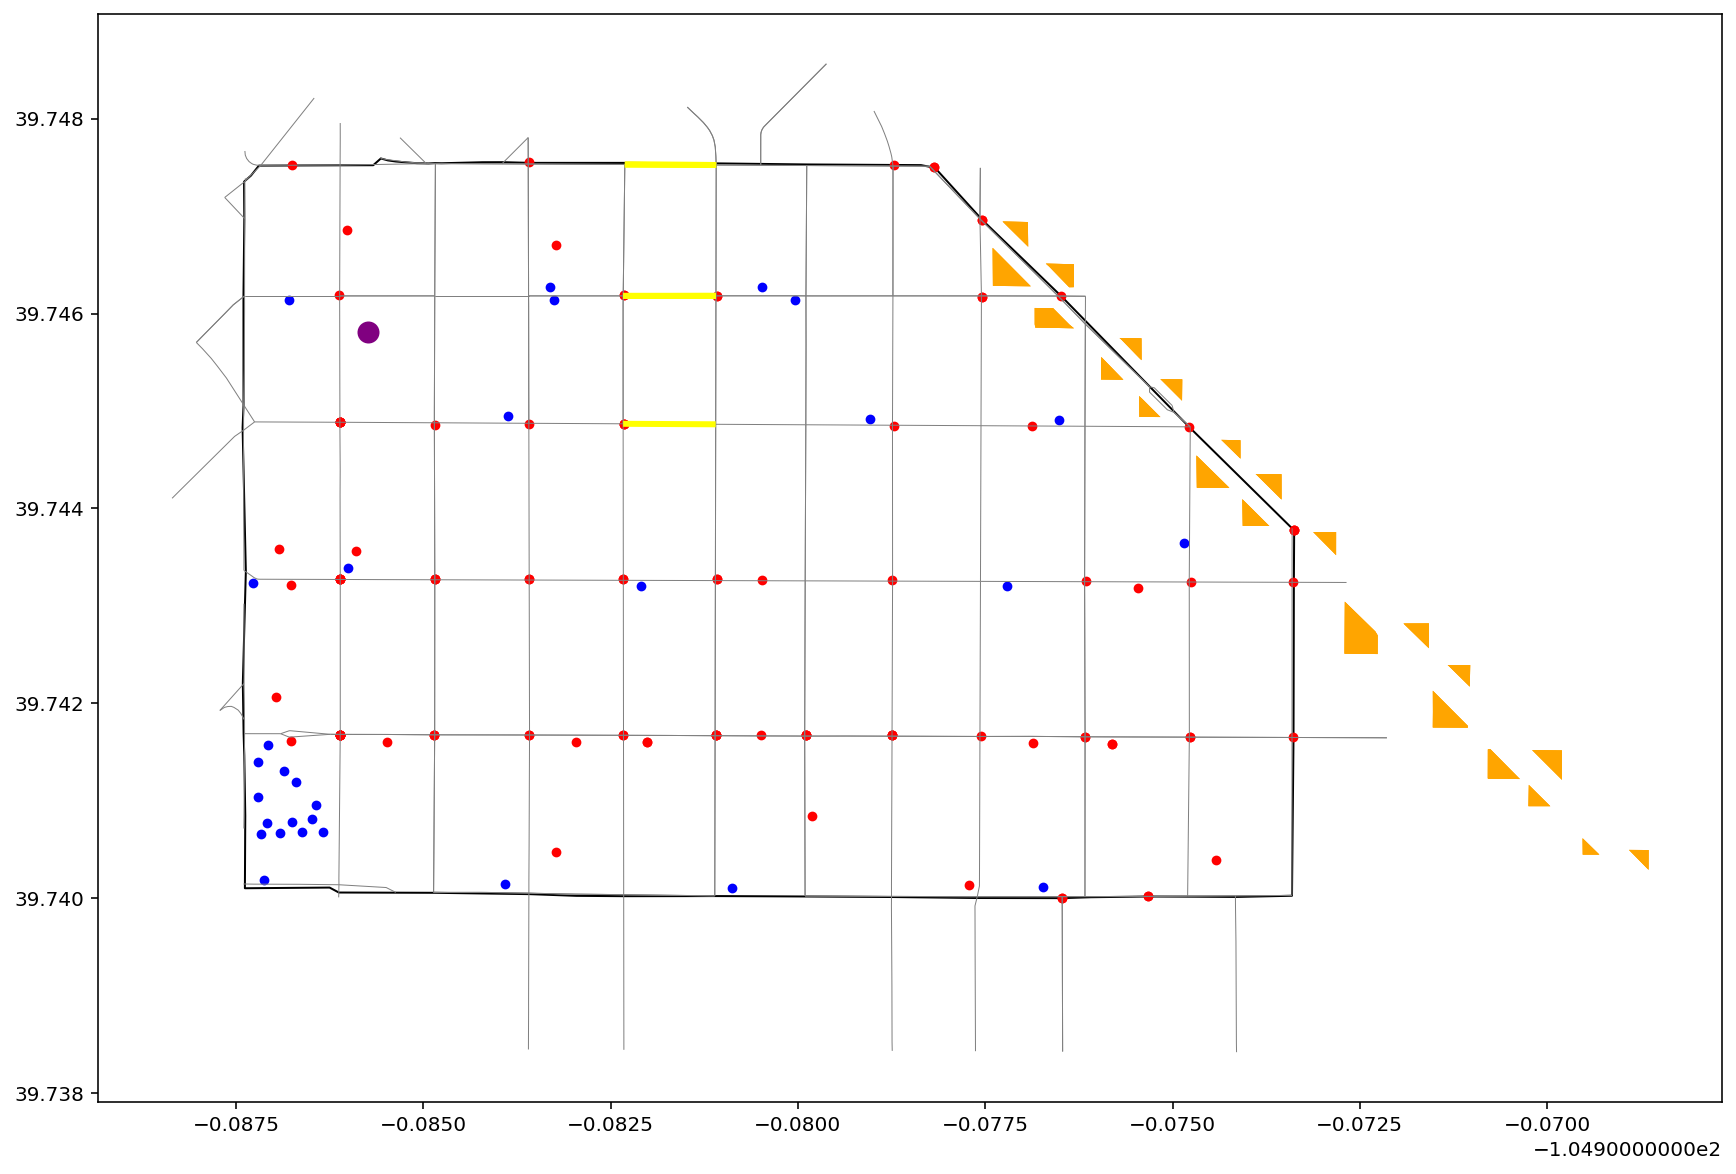

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[0]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
nch_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_nch_streets.plot(ax = base, color = "yellow", linewidth = 3)
nch_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
nch_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
nch_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
nch_parks.plot(ax = base, color = "orange")
nch_schools.plot(ax = base, color = "purple", markersize = 100);

### City Park West

Subsetting streets within City Park West.

In [169]:
cpw_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[1]])

Creating 1/4 mile buffers around cpw_streets.

In [170]:
cpw_buffers = cpw_streets.copy()
cpw_buffers["geometry"] = cpw_buffers["geometry"].buffer(buff)

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_94416/2984639996.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cpw_buffers["geometry"] = cpw_buffers["geometry"].buffer(buff)


Subsetting crashes within CPW.

In [171]:
cpw_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[1]])

Calculating the percentage of crashes within each street buffer in CPW.

In [172]:
cpw_crashes = cpw_crashes.drop(["index_right"], axis = 1)
cpw_buffers = cpw_buffers.drop(["index_right"], axis = 1)

cpw_street_crashes = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_crashes.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_crashes[i] = len(newdat) / len(cpw_crashes);

Subsetting all Key Destination data within CPW.

In [173]:
#subsetting data
cpw_parks = park_data.sjoin(nbrhds_of_interest.iloc[[1]])
cpw_schools = school_data.sjoin(nbrhds_of_interest.iloc[[1]])
cpw_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[1]])
cpw_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[1]])

Calculating the percentage of parks within each street buffer in CPW.

In [174]:
cpw_parks = cpw_parks.drop(["index_right"], axis = 1)

cpw_street_parks = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_parks.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_parks[i] = len(newdat) / len(cpw_parks);

Calculating the percentage of schools within each street buffer in CPW.

In [175]:
cpw_schools = cpw_schools.drop(["index_right"], axis = 1)

cpw_street_schools = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_schools.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_schools[i] = len(newdat) / len(cpw_schools);

Calculating the percentage of bus stops within each street buffer in CPW.

In [176]:
cpw_bus_stops = cpw_bus_stops.drop(["index_right"], axis = 1)

cpw_street_bus_stops = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_bus_stops.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_bus_stops[i] = len(newdat) / len(cpw_bus_stops);

There are no lightrail stops in CPW, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "cpw_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [177]:
cpw_events = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  cpw_events[i] = cpw_street_crashes[i] + cpw_street_parks[i] + cpw_street_schools[i] + cpw_street_bus_stops[i]

cpw_streets.insert(1, "CPW_EVENTS", cpw_events, False)

best_cpw_streets = cpw_streets.sort_values(by = ["CPW_EVENTS"], ascending = False)[0:5]

Printing names of best CPW streets.

In [178]:
for i in range(len(best_cpw_streets)):
  print("Street", i+1)
  print(best_cpw_streets.name.iloc[i]) #, "from", best_cpw_streets.FROMNAME.iloc[i], "to", best_cpw_streets.TONAME.iloc[i])

Street 1
Lafayette Street
Street 2
Lafayette Street
Street 3
['Lafayette Street', 'East 19th Avenue']
Street 4
['Lafayette Street', 'East 19th Avenue']
Street 5
East 18th Avenue


Plotting best streets in CPW.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


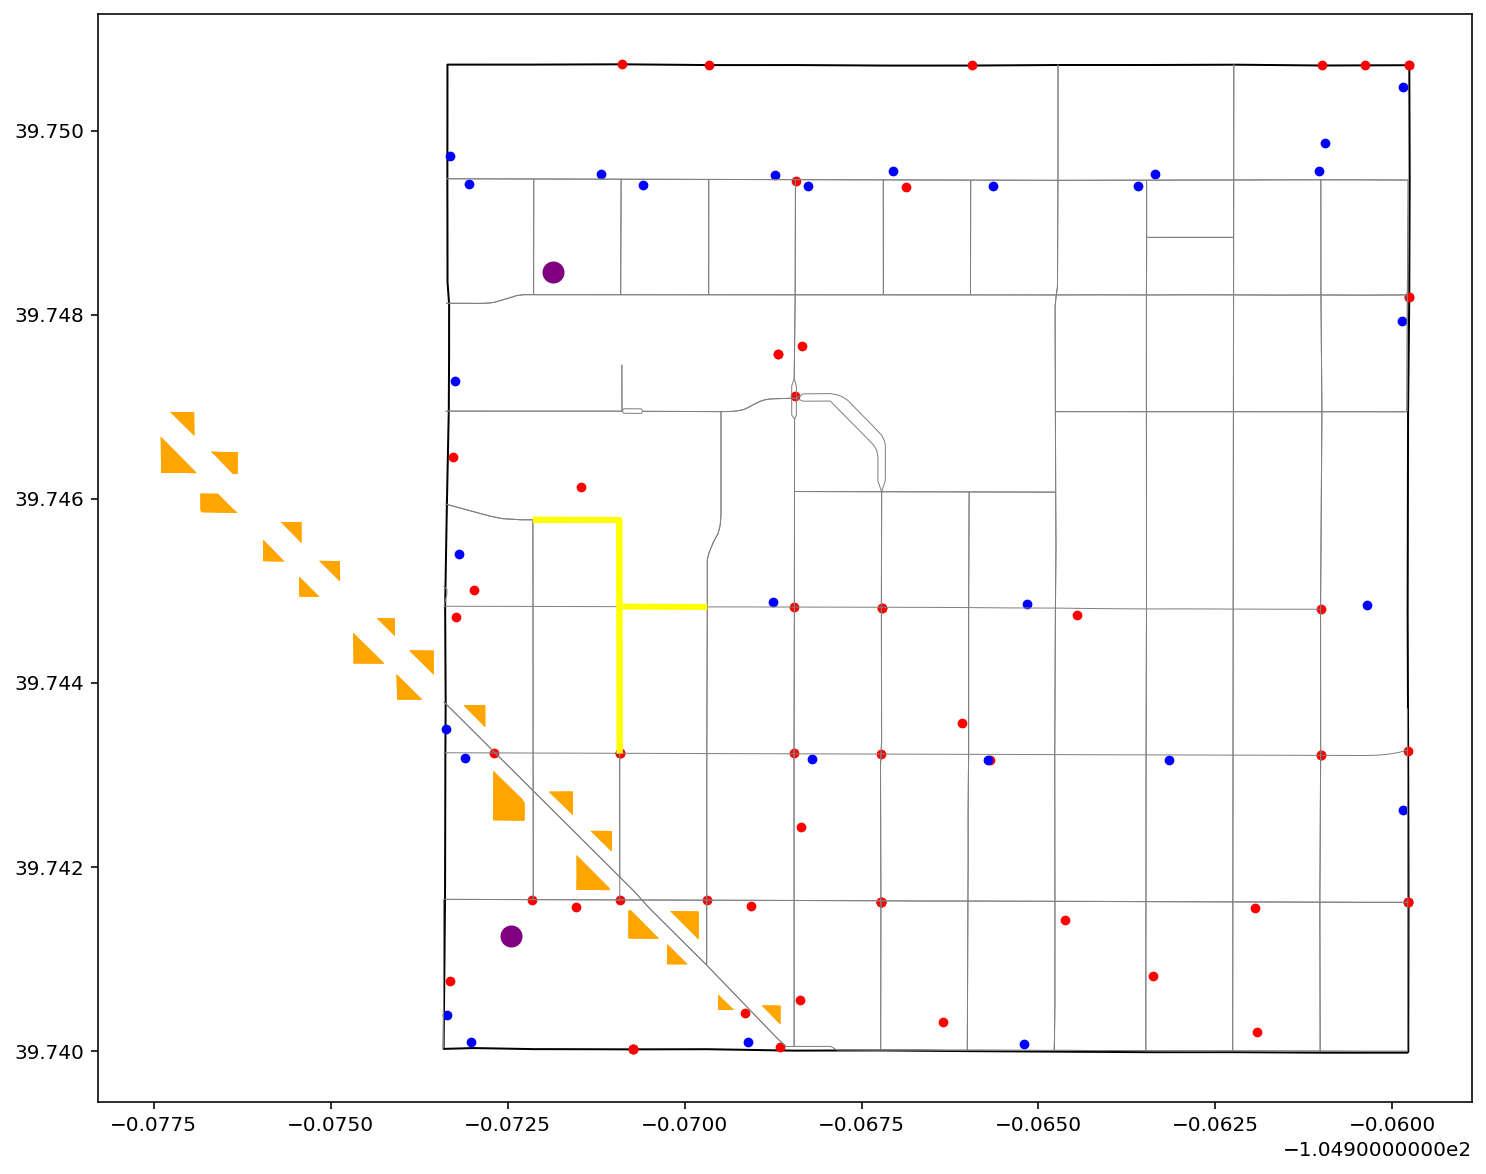

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[1]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
cpw_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_cpw_streets.plot(ax = base, color = "yellow", linewidth = 3)
cpw_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
cpw_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
cpw_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
cpw_parks.plot(ax = base, color = "orange")
cpw_schools.plot(ax = base, color = "purple", markersize = 100);

### Capitol Hill

Subsetting streets within Capitol Hill.

In [180]:
ch_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[2]])

Creating 1/4 mile buffers around ch_streets.

In [181]:
ch_buffers = ch_streets.copy()
ch_buffers["geometry"] = ch_buffers["geometry"].buffer(buff)

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_94416/1134712639.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ch_buffers["geometry"] = ch_buffers["geometry"].buffer(buff)


Subsetting crashes within CH.

In [182]:
ch_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[2]])

Calculating the percentage of crashes within each street buffer in CH.

In [183]:
ch_crashes = ch_crashes.drop(["index_right"], axis = 1)
ch_buffers = ch_buffers.drop(["index_right"], axis = 1)

ch_street_crashes = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_crashes.sjoin(ch_buffers.iloc[[i]])
  ch_street_crashes[i] = len(newdat) / len(ch_crashes);

Subsetting all Key Destination data within CH.

In [184]:
#subsetting data
ch_parks = park_data.sjoin(nbrhds_of_interest.iloc[[2]])
ch_schools = school_data.sjoin(nbrhds_of_interest.iloc[[2]])
ch_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[2]])
ch_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[2]])

Calculating the percentage of parks within each street buffer in CH.

In [185]:
ch_parks = ch_parks.drop(["index_right"], axis = 1)

ch_street_parks = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_parks.sjoin(ch_buffers.iloc[[i]])
  ch_street_parks[i] = len(newdat) / len(ch_parks);

Calculating the percentage of schools within each street buffer in CH.

In [186]:
ch_schools = ch_schools.drop(["index_right"], axis = 1)

ch_street_schools = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_schools.sjoin(ch_buffers.iloc[[i]])
  ch_street_schools[i] = len(newdat) / len(ch_schools);

Calculating the percentage of bus stops within each street buffer in CH.

In [187]:
ch_bus_stops = ch_bus_stops.drop(["index_right"], axis = 1)

ch_street_bus_stops = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_bus_stops.sjoin(ch_buffers.iloc[[i]])
  ch_street_bus_stops[i] = len(newdat) / len(ch_bus_stops);

There are no lightrail stops in CH, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "ch_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [188]:
ch_events = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  ch_events[i] = ch_street_crashes[i] + ch_street_parks[i] + ch_street_schools[i] + ch_street_bus_stops[i]

ch_streets.insert(1, "CH_EVENTS", ch_events, False)

best_ch_streets = ch_streets.sort_values(by = ["CH_EVENTS"], ascending = False)[0:5]

Printing names of best CH streets.

In [189]:
for i in range(len(best_ch_streets)):
  print("Street", i+1)
  print(best_ch_streets.name.iloc[i]) #, "from", best_ch_streets.FROMNAME.iloc[i], "to", best_ch_streets.TONAME.iloc[i])

Street 1
Clarkson Street
Street 2
East 9th Avenue
Street 3
East 9th Avenue
Street 4
Clarkson Street
Street 5
East 9th Avenue


Plotting best streets in CH.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


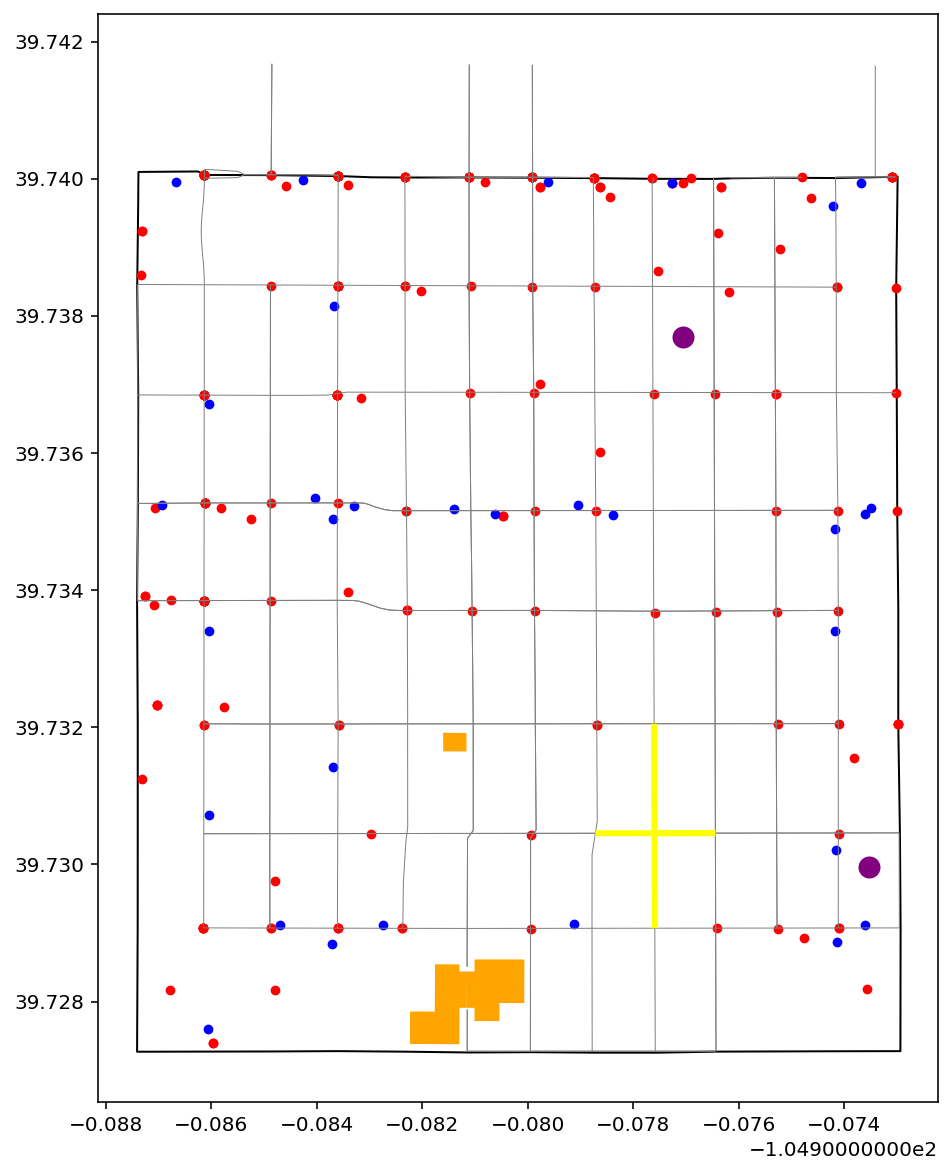

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[2]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
ch_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_ch_streets.plot(ax = base, color = "yellow", linewidth = 3)
ch_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
ch_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
ch_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
ch_parks.plot(ax = base, color = "orange")
ch_schools.plot(ax = base, color = "purple", markersize = 100);

### Five Points

Subsetting streets within Five Points.

In [191]:
fp_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[3]])

Creating 1/4 mile buffers around fp_streets.

In [192]:
fp_buffers = fp_streets.copy()
fp_buffers["geometry"] = fp_buffers["geometry"].buffer(buff)

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_94416/1441577887.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  fp_buffers["geometry"] = fp_buffers["geometry"].buffer(buff)


Subsetting crashes within FP.

In [193]:
fp_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[3]])

Calculating the percentage of crashes within each street buffer in FP.

In [194]:
fp_crashes = fp_crashes.drop(["index_right"], axis = 1)
fp_buffers = fp_buffers.drop(["index_right"], axis = 1)

fp_street_crashes = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_crashes.sjoin(fp_buffers.iloc[[i]])
  fp_street_crashes[i] = len(newdat) / len(fp_crashes);

Subsetting all Key Destination data within FP.

In [195]:
#subsetting data
fp_parks = park_data.sjoin(nbrhds_of_interest.iloc[[3]])
fp_schools = school_data.sjoin(nbrhds_of_interest.iloc[[3]])
fp_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[3]])
fp_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[3]])

Calculating the percentage of parks within each street buffer in FP.

In [196]:
fp_parks = fp_parks.drop(["index_right"], axis = 1)

fp_street_parks = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_parks.sjoin(fp_buffers.iloc[[i]])
  fp_street_parks[i] = len(newdat) / len(fp_parks);

Calculating the percentage of schools within each street buffer in FP.

In [197]:
fp_schools = fp_schools.drop(["index_right"], axis = 1)

fp_street_schools = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_schools.sjoin(fp_buffers.iloc[[i]])
  fp_street_schools[i] = len(newdat) / len(fp_schools);

Calculating the percentage of bus stops within each street buffer in FP.

In [198]:
fp_bus_stops = fp_bus_stops.drop(["index_right"], axis = 1)

fp_street_bus_stops = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_bus_stops.sjoin(fp_buffers.iloc[[i]])
  fp_street_bus_stops[i] = len(newdat) / len(fp_bus_stops);

Calculating the percentage of lightrail stops within each street buffer in FP.

In [199]:
fp_lightrail_stops = fp_lightrail_stops.drop(["index_right"], axis = 1)

fp_street_lightrail_stops = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_lightrail_stops.sjoin(fp_buffers.iloc[[i]])
  fp_street_lightrail_stops[i] = len(newdat) / len(fp_lightrail_stops);

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "fp_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [200]:
fp_events = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  fp_events[i] = fp_street_crashes[i] + fp_street_parks[i] + fp_street_schools[i] + fp_street_bus_stops[i] + fp_street_lightrail_stops[i]

fp_streets.insert(1, "FP_EVENTS", fp_events, False)

best_fp_streets = fp_streets.sort_values(by = ["FP_EVENTS"], ascending = False)[0:5]

Printing names of best FP streets.

In [201]:
for i in range(len(best_fp_streets)):
  print("Street", i+1)
  print(best_fp_streets.name.iloc[i]) #, "from", best_fp_streets.FROMNAME.iloc[i], "to", best_fp_streets.TONAME.iloc[i])

Street 1
California Street
Street 2
California Street
Street 3
Stout Street
Street 4
28th Street
Street 5
28th Street


Plotting best streets in FP.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


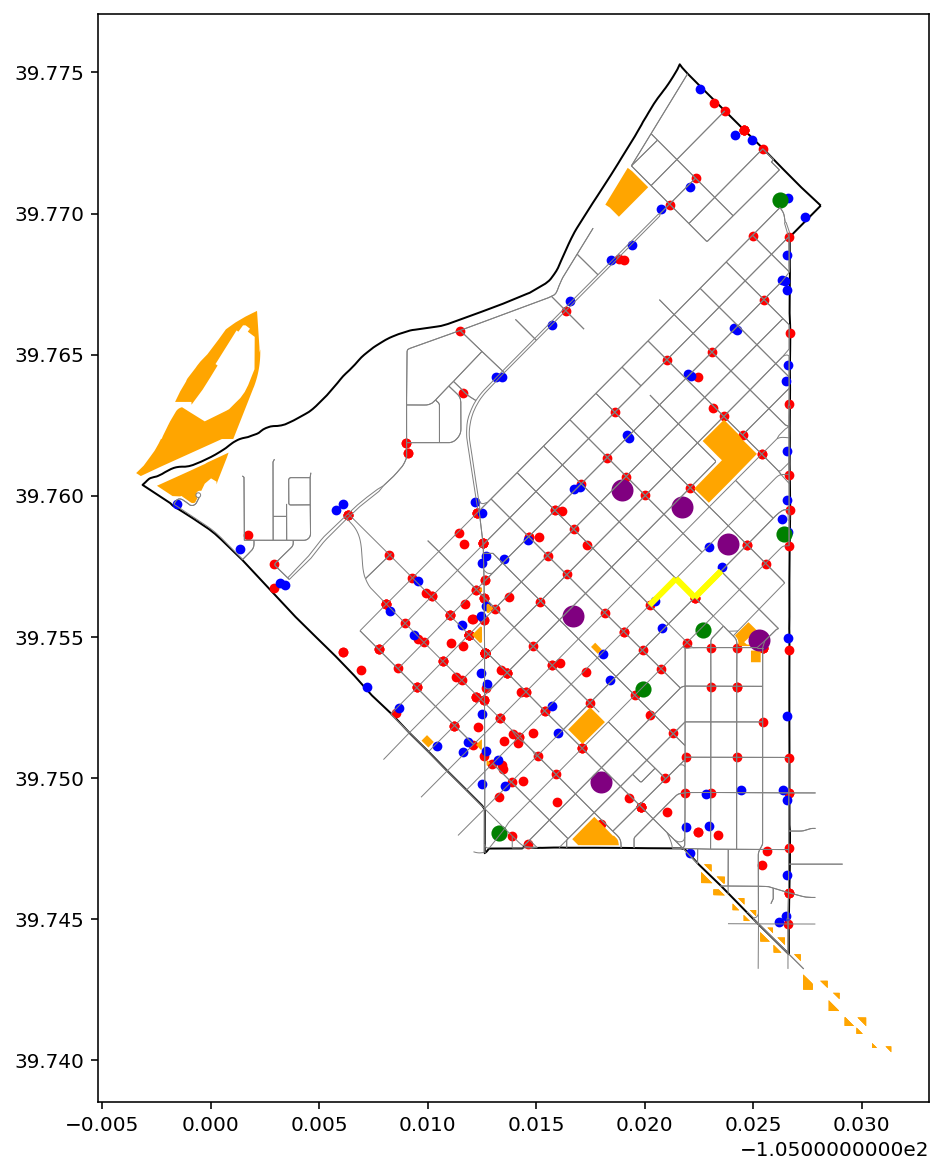

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[3]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
fp_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_fp_streets.plot(ax = base, color = "yellow", linewidth = 3)
fp_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
fp_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
fp_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
fp_parks.plot(ax = base, color = "orange")
fp_schools.plot(ax = base, color = "purple", markersize = 100);

### Central Business District

Subsetting streets within Central Business District.

In [203]:
cbd_streets = street_edges.sjoin(nbrhds_of_interest.iloc[[4]])

Creating 1/4 mile buffers around cbd_streets.

In [204]:
cbd_buffers = cbd_streets.copy()
cbd_buffers["geometry"] = cbd_buffers["geometry"].buffer(buff)

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_94416/914653158.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cbd_buffers["geometry"] = cbd_buffers["geometry"].buffer(buff)


Subsetting crashes within CBD.

In [205]:
cbd_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[4]])

Calculating the percentage of crashes within each street buffer in CBD.

In [206]:
cbd_crashes = cbd_crashes.drop(["index_right"], axis = 1)
cbd_buffers = cbd_buffers.drop(["index_right"], axis = 1)

cbd_street_crashes = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_crashes.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_crashes[i] = len(newdat) / len(cbd_crashes);

Subsetting all Key Destination data within CBD.

In [207]:
#subsetting data
cbd_parks = park_data.sjoin(nbrhds_of_interest.iloc[[4]])
cbd_schools = school_data.sjoin(nbrhds_of_interest.iloc[[4]])
cbd_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[4]])
cbd_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[4]])

Calculating the percentage of parks within each street buffer in CBD.

In [208]:
cbd_parks = cbd_parks.drop(["index_right"], axis = 1)

cbd_street_parks = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_parks.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_parks[i] = len(newdat) / len(cbd_parks);

There are no schools in CBD, so that will not be calculated.

Calculating the percentage of bus stops within each street buffer in CBD.

In [209]:
cbd_bus_stops = cbd_bus_stops.drop(["index_right"], axis = 1)

cbd_street_bus_stops = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_bus_stops.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_bus_stops[i] = len(newdat) / len(cbd_bus_stops);

Calculating the percentage of lightrail stops within each street buffer in CBD.

In [210]:
cbd_lightrail_stops = cbd_lightrail_stops.drop(["index_right"], axis = 1)

cbd_street_lightrail_stops = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_lightrail_stops.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_lightrail_stops[i] = len(newdat) / len(cbd_lightrail_stops);

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "cbd_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [211]:
cbd_events = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  cbd_events[i] = cbd_street_crashes[i] + cbd_street_parks[i] + cbd_street_bus_stops[i] + cbd_street_lightrail_stops[i]

cbd_streets.insert(1, "CBD_EVENTS", cbd_events, False)

best_cbd_streets = cbd_streets.sort_values(by = ["CBD_EVENTS"], ascending = False)[0:5]

Printing names of best CBD streets.

In [212]:
for i in range(len(best_cbd_streets)):
  print("Street", i+1)
  print(best_cbd_streets.name.iloc[i]) #, "from", best_cbd_streets.FROMNAME.iloc[i], "to", best_cbd_streets.TONAME.iloc[i])

Street 1
Stout Street
Street 2
Curtis Street
Street 3
Champa Street
Street 4
California Street
Street 5
Welton Street


Plotting best streets in CBD.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


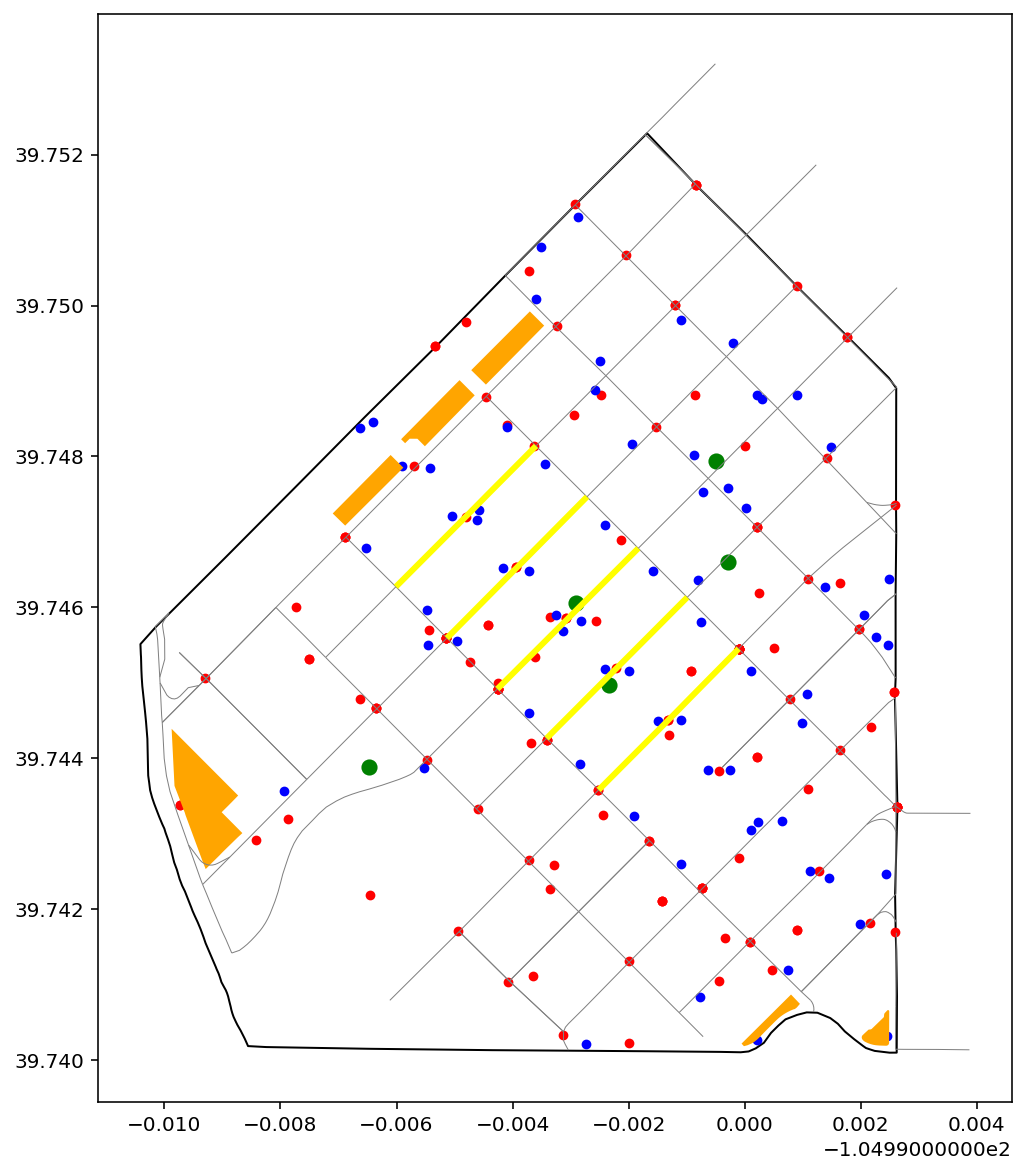

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[4]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
cbd_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_cbd_streets.plot(ax = base, color = "yellow", linewidth = 3)
cbd_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
cbd_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
cbd_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
cbd_parks.plot(ax = base, color = "orange");

# Best Neighborhoods and Streets

Displaying the best neighborhoods for shared street development.

In [214]:
nbrhds_of_interest

NBRHD_NAME  SOCIOECON_SCORE  ACCESSTOCARE_SCORE  MORBIDITY_SCORE  \
5   North Capitol Hill              3.0                 2.0              2.5   
15      City Park West              2.5                 3.0              2.0   
4         Capitol Hill              4.0                 2.5              4.0   
19         Five Points              2.5                 1.5              3.5   
7                  CBD              2.5                 2.0              4.0   

    MORTALITY_SCORE  BUILTENV_SCORE  OVERALLEQUITY_SCORE  EQUITY_SCORE_10  \
5               1.0             5.0                  2.7         5.744681   
15              1.0             4.0                  2.5         5.319149   
4               1.0             4.0                  3.1         6.595745   
19              1.0             3.5                  2.4         5.106383   
7               5.0             5.0                  3.7         7.872341   

    AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  SHAPE_Length  SHAPE_Area  \
5        8.916667    9.950766         4.206085      0.040371    0.000096   
15       7.714286    8.608940         3.289791      0.048647    0.000146   
4        8.736842    9.750086         3.154342      0.054472    0.000184   
19       6.525000    7.281729         2.175345      0.102129    0.000479   
7        8.960784   10.000000         2.127659      0.042534    0.000117   

                                             geometry  
5   MULTIPOLYGON (((-104.97338 39.74378, -104.9733...  
15  MULTIPOLYGON (((-104.95978 39.73999, -104.9604...  
4   MULTIPOLYGON (((-104.97341 39.74003, -104.9729...  
19  MULTIPOLYGON (((-104.97192 39.77030, -104.9733...  
7   MULTIPOLYGON (((-104.98740 39.74736, -104.9874...

Plotting the best neighborhoods for shared street development.

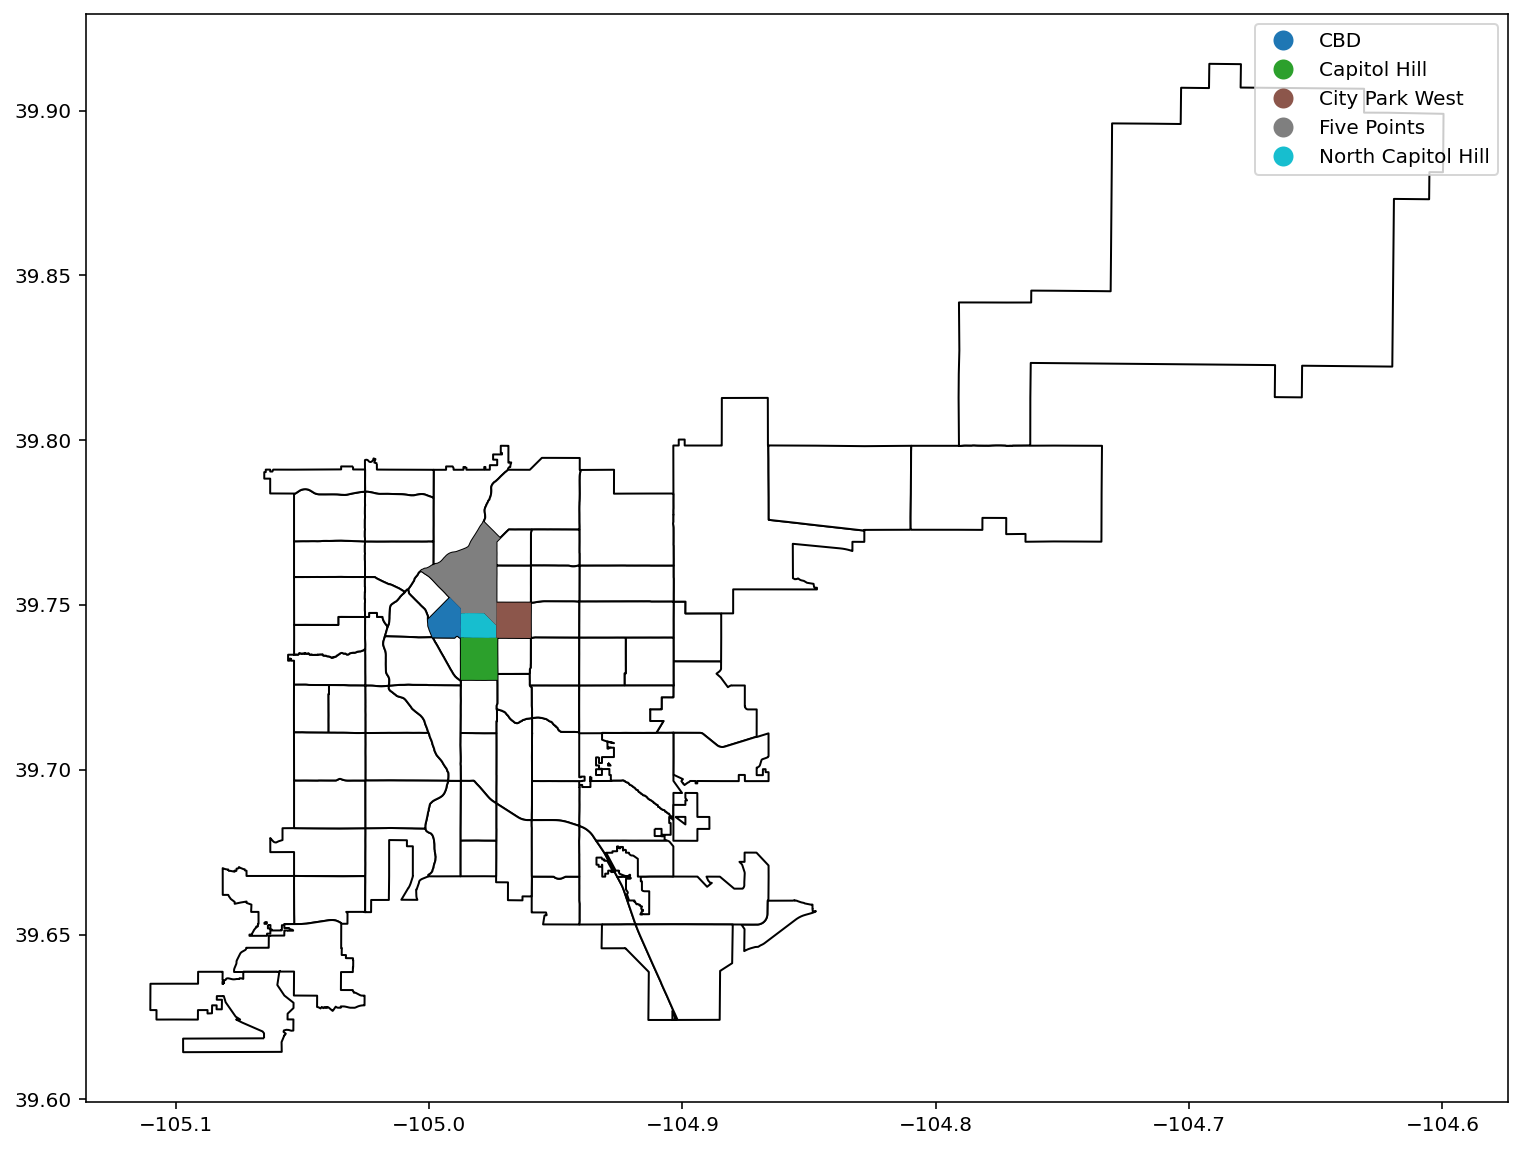

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(15,10), facecolor="white")
base = equity_data.plot(ax=ax, color = "white", edgecolor = "black")
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=base, legend=True);

Displaying the indices and names of the best streets for development in each neighborhood.

North Capitol Hill:

In [216]:
best_nch_streets

osmid  NCH_EVENTS lanes              name  \
u         v          key                                                   
176086235 4955447713 0     130919107    2.812963     3  East 18th Avenue   
176097378 176086237  0    1039146327    2.585185     2  East 19th Avenue   
176086237 176097378  0    1039146327    2.585185     2  East 19th Avenue   
176086239 176088606  0     231105093    2.394444     2  East 20th Avenue   
176088606 176086239  0     231105093    2.394444     2  East 20th Avenue   

                            highway  oneway   length  \
u         v          key                               
176086235 4955447713 0    secondary    True  105.643   
176097378 176086237  0     tertiary   False  105.853   
176086237 176097378  0     tertiary   False  105.853   
176086239 176088606  0     tertiary   False  104.263   
176088606 176086239  0     tertiary   False  104.263   

                                                                   geometry  \
u         v          key                                                      
176086235 4955447713 0    LINESTRING (-104.98110 39.74486, -104.98122 39...   
176097378 176086237  0    LINESTRING (-104.98233 39.74618, -104.98222 39...   
176086237 176097378  0    LINESTRING (-104.98109 39.74618, -104.98122 39...   
176086239 176088606  0    LINESTRING (-104.98109 39.74752, -104.98120 39...   
176088606 176086239  0    LINESTRING (-104.98231 39.74753, -104.98221 39...   

                         maxspeed  ref  ... MORBIDITY_SCORE MORTALITY_SCORE  \
u         v          key                ...                                   
176086235 4955447713 0     30 mph  NaN  ...             2.5             1.0   
176097378 176086237  0        NaN  NaN  ...             2.5             1.0   
176086237 176097378  0        NaN  NaN  ...             2.5             1.0   
176086239 176088606  0        NaN  NaN  ...             2.5             1.0   
176088606 176086239  0        NaN  NaN  ...             2.5             1.0   

                         BUILTENV_SCORE  OVERALLEQUITY_SCORE EQUITY_SCORE_10  \
u         v          key                                                       
176086235 4955447713 0              5.0                  2.7        5.744681   
176097378 176086237  0              5.0                  2.7        5.744681   
176086237 176097378  0              5.0                  2.7        5.744681   
176086239 176088606  0              5.0                  2.7        5.744681   
176088606 176086239  0              5.0                  2.7        5.744681   

                          AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  \
u         v          key                                               
176086235 4955447713 0         8.916667    9.950766         4.206085   
176097378 176086237  0         8.916667    9.950766         4.206085   
176086237 176097378  0         8.916667    9.950766         4.206085   
176086239 176088606  0         8.916667    9.950766         4.206085   
176088606 176086239  0         8.916667    9.950766         4.206085   

                          SHAPE_Length  SHAPE_Area  
u         v          key                            
176086235 4955447713 0        0.040371    0.000096  
176097378 176086237  0        0.040371    0.000096  
176086237 176097378  0        0.040371    0.000096  
176086239 176088606  0        0.040371    0.000096  
176088606 176086239  0        0.040371    0.000096  

[5 rows x 27 columns]

In [217]:
for i in range(len(best_nch_streets)):
  print("Street", i+1)
  print(best_nch_streets.name.iloc[i])# , "from", best_nch_streets.FROMNAME.iloc[i], "to", best_nch_streets.TONAME.iloc[i])

Street 1
East 18th Avenue
Street 2
East 19th Avenue
Street 3
East 19th Avenue
Street 4
East 20th Avenue
Street 5
East 20th Avenue


City Park West:

In [218]:
best_cpw_streets

osmid  CPW_EVENTS  \
u          v          key                                                  
4435531507 176080675  0                            581254411    2.877011   
176080675  4435531507 0                            581254411    2.877011   
3358646006 4435531507 0    [628620744, 581254411, 628620742]    2.693678   
4435531507 3358646006 0    [628620744, 581254411, 628620742]    2.693678   
176093803  4435531507 0                            446310361    2.673563   

                            lanes                                  name  \
u          v          key                                                 
4435531507 176080675  0         2                      Lafayette Street   
176080675  4435531507 0         2                      Lafayette Street   
3358646006 4435531507 0    [2, 3]  [Lafayette Street, East 19th Avenue]   
4435531507 3358646006 0    [2, 3]  [Lafayette Street, East 19th Avenue]   
176093803  4435531507 0         3                      East 18th Avenue   

                               highway  oneway   length  \
u          v          key                                 
4435531507 176080675  0    residential   False  177.167   
176080675  4435531507 0    residential   False  177.167   
3358646006 4435531507 0    residential   False  209.064   
4435531507 3358646006 0    residential   False  209.064   
176093803  4435531507 0      secondary    True  106.137   

                                                                    geometry  \
u          v          key                                                      
4435531507 176080675  0    LINESTRING (-104.97092 39.74483, -104.97092 39...   
176080675  4435531507 0    LINESTRING (-104.97092 39.74324, -104.97092 39...   
3358646006 4435531507 0    LINESTRING (-104.97214 39.74577, -104.97201 39...   
4435531507 3358646006 0    LINESTRING (-104.97092 39.74483, -104.97092 39...   
176093803  4435531507 0    LINESTRING (-104.96968 39.74483, -104.96981 39...   

                          maxspeed  ref  ... MORBIDITY_SCORE MORTALITY_SCORE  \
u          v          key                ...                                   
4435531507 176080675  0        NaN  NaN  ...             2.0             1.0   
176080675  4435531507 0        NaN  NaN  ...             2.0             1.0   
3358646006 4435531507 0        NaN  NaN  ...             2.0             1.0   
4435531507 3358646006 0        NaN  NaN  ...             2.0             1.0   
176093803  4435531507 0     30 mph  NaN  ...             2.0             1.0   

                          BUILTENV_SCORE  OVERALLEQUITY_SCORE EQUITY_SCORE_10  \
u          v          key                                                       
4435531507 176080675  0              4.0                  2.5        5.319149   
176080675  4435531507 0              4.0                  2.5        5.319149   
3358646006 4435531507 0              4.0                  2.5        5.319149   
4435531507 3358646006 0              4.0                  2.5        5.319149   
176093803  4435531507 0              4.0                  2.5        5.319149   

                           AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  \
u          v          key                                               
4435531507 176080675  0         7.714286     8.60894         3.289791   
176080675  4435531507 0         7.714286     8.60894         3.289791   
3358646006 4435531507 0         7.714286     8.60894         3.289791   
4435531507 3358646006 0         7.714286     8.60894         3.289791   
176093803  4435531507 0         7.714286     8.60894         3.289791   

                           SHAPE_Length  SHAPE_Area  
u          v          key                            
4435531507 176080675  0        0.048647    0.000146  
176080675  4435531507 0        0.048647    0.000146  
3358646006 4435531507 0        0.048647    0.000146  
4435531507 3358646006 0        0.048647    0.000146  
176093803  4435531507 0        0.048647    0.000146  

[

In [219]:
for i in range(len(best_cpw_streets)):
  print("Street", i+1)
  print(best_cpw_streets.name.iloc[i]) #, "from", best_cpw_streets.FROMNAME.iloc[i], "to", best_cpw_streets.TONAME.iloc[i])

Street 1
Lafayette Street
Street 2
Lafayette Street
Street 3
['Lafayette Street', 'East 19th Avenue']
Street 4
['Lafayette Street', 'East 19th Avenue']
Street 5
East 18th Avenue


Capitol Hill:

In [220]:
best_ch_streets

osmid  CH_EVENTS   lanes  \
u          v          key                                              
3442474977 3405259189 0    [335805945, 628684573]   1.805224  [1, 2]   
3442481922 3442474977 0                 337912746   1.772965       2   
3442474977 3442481922 0                 337912746   1.772965       2   
176089093  3442474977 0                 628684573   1.715327       1   
1341986925 3442474977 0                 337912746   1.698297       2   

                                      name      highway  oneway   length  \
u          v          key                                                  
3442474977 3405259189 0    Clarkson Street     tertiary    True  177.557   
3442481922 3442474977 0    East 9th Avenue  residential   False   98.744   
3442474977 3442481922 0    East 9th Avenue  residential   False   98.744   
176089093  3442474977 0    Clarkson Street     tertiary    True  154.073   
1341986925 3442474977 0    East 9th Avenue  residential   False   95.871   

                                                                    geometry  \
u          v          key                                                      
3442474977 3405259189 0    LINESTRING (-104.97759 39.73046, -104.97759 39...   
3442481922 3442474977 0    LINESTRING (-104.97644 39.73046, -104.97652 39...   
3442474977 3442481922 0    LINESTRING (-104.97759 39.73046, -104.97750 39...   
176089093  3442474977 0    LINESTRING (-104.97759 39.72907, -104.97759 39...   
1341986925 3442474977 0    LINESTRING (-104.97871 39.73045, -104.97859 39...   

                          maxspeed  ref  ... MORBIDITY_SCORE MORTALITY_SCORE  \
u          v          key                ...                                   
3442474977 3405259189 0     30 mph  NaN  ...             4.0             1.0   
3442481922 3442474977 0        NaN  NaN  ...             4.0             1.0   
3442474977 3442481922 0        NaN  NaN  ...             4.0             1.0   
176089093  3442474977 0        NaN  NaN  ...             4.0             1.0   
1341986925 3442474977 0        NaN  NaN  ...             4.0             1.0   

                          BUILTENV_SCORE  OVERALLEQUITY_SCORE EQUITY_SCORE_10  \
u          v          key                                                       
3442474977 3405259189 0              4.0                  3.1        6.595745   
3442481922 3442474977 0              4.0                  3.1        6.595745   
3442474977 3442481922 0              4.0                  3.1        6.595745   
176089093  3442474977 0              4.0                  3.1        6.595745   
1341986925 3442474977 0              4.0                  3.1        6.595745   

                           AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  \
u          v          key                                               
3442474977 3405259189 0         8.736842    9.750086         3.154342   
3442481922 3442474977 0         8.736842    9.750086         3.154342   
3442474977 3442481922 0         8.736842    9.750086         3.154342   
176089093  3442474977 0         8.736842    9.750086         3.154342   
1341986925 3442474977 0         8.736842    9.750086         3.154342   

                           SHAPE_Length  SHAPE_Area  
u          v          key                            
3442474977 3405259189 0        0.054472    0.000184  
3442481922 3442474977 0        0.054472    0.000184  
3442474977 3442481922 0        0.054472    0.000184  
176089093  3442474977 0        0.054472    0.000184  
1341986925 3442474977 0        0.054472    0.000184  

[5 rows x 27 columns]

In [221]:
for i in range(len(best_ch_streets)):
  print("Street", i+1)
  print(best_ch_streets.name.iloc[i]) #, "from", best_ch_streets.FROMNAME.iloc[i], "to", best_ch_streets.TONAME.iloc[i])

Street 1
Clarkson Street
Street 2
East 9th Avenue
Street 3
East 9th Avenue
Street 4
Clarkson Street
Street 5
East 9th Avenue


Five Points:

In [222]:
best_fp_streets

osmid  FP_EVENTS lanes               name  \
u         v         key                                                  
176092321 176092319 0    781164692   1.513470     2  California Street   
176092319 176092321 0    781164692   1.513470     2  California Street   
176104953 176093067 0     88625482   1.447077     2       Stout Street   
176092319 176093067 0    674354857   1.430754   NaN        28th Street   
176093067 176092319 0    674354857   1.430754   NaN        28th Street   

                             highway  oneway   length  \
u         v         key                                 
176092321 176092319 0       tertiary   False  146.583   
176092319 176092321 0       tertiary   False  146.583   
176104953 176093067 0      secondary    True  146.822   
176092319 176093067 0    residential   False  105.071   
176093067 176092319 0    residential   False  105.071   

                                                                  geometry  \
u         v         key                                                      
176092321 176092319 0    LINESTRING (-104.97649 39.75734, -104.97658 39...   
176092319 176092321 0    LINESTRING (-104.97770 39.75640, -104.97762 39...   
176104953 176093067 0    LINESTRING (-104.97978 39.75613, -104.97969 39...   
176092319 176093067 0    LINESTRING (-104.97770 39.75640, -104.97779 39...   
176093067 176092319 0    LINESTRING (-104.97857 39.75707, -104.97849 39...   

                        maxspeed  ref  ... MORBIDITY_SCORE MORTALITY_SCORE  \
u         v         key                ...                                   
176092321 176092319 0     25 mph  NaN  ...             3.5             1.0   
176092319 176092321 0     25 mph  NaN  ...             3.5             1.0   
176104953 176093067 0     30 mph  NaN  ...             3.5             1.0   
176092319 176093067 0        NaN  NaN  ...             3.5             1.0   
176093067 176092319 0        NaN  NaN  ...             3.5             1.0   

                        BUILTENV_SCORE  OVERALLEQUITY_SCORE EQUITY_SCORE_10  \
u         v         key                                                       
176092321 176092319 0              3.5                  2.4        5.106383   
176092319 176092321 0              3.5                  2.4        5.106383   
176104953 176093067 0              3.5                  2.4        5.106383   
176092319 176093067 0              3.5                  2.4        5.106383   
176093067 176092319 0              3.5                  2.4        5.106383   

                         AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  \
u         v         key                                               
176092321 176092319 0            6.525    7.281729         2.175345   
176092319 176092321 0            6.525    7.281729         2.175345   
176104953 176093067 0            6.525    7.281729         2.175345   
176092319 176093067 0            6.525    7.281729         2.175345   
176093067 176092319 0            6.525    7.281729         2.175345   

                         SHAPE_Length  SHAPE_Area  
u         v         key                            
176092321 176092319 0        0.102129    0.000479  
176092319 176092321 0        0.102129    0.000479  
176104953 176093067 0        0.102129    0.000479  
176092319 176093067 0        0.102129    0.000479  
176093067 176092319 0        0.102129    0.000479  

[5 rows x 27 columns]

In [223]:
for i in range(len(best_fp_streets)):
  print("Street", i+1)
  print(best_fp_streets.name.iloc[i]) #, "from", best_fp_streets.FROMNAME.iloc[i], "to", best_fp_streets.TONAME.iloc[i])

Street 1
California Street
Street 2
California Street
Street 3
Stout Street
Street 4
28th Street
Street 5
28th Street


Central Business District:

In [224]:
best_cbd_streets

osmid  \
u          v         key                                                 
176113163  176094617 0              [960107212, 960107214, 1051799390]   
3114170041 176081475 0    [317974696, 628389291, 907240288, 907240285]   
176094619  176112279 0               [130885096, 922432402, 922432399]   
661835900  661834861 0    [130921921, 628389306, 905299147, 905299150]   
176085794  176085790 0    [130885104, 628389329, 798190257, 628389333]   

                          CBD_EVENTS   lanes               name    highway  \
u          v         key                                                     
176113163  176094617 0      2.661670       2       Stout Street  secondary   
3114170041 176081475 0      2.564789  [2, 3]      Curtis Street   tertiary   
176094619  176112279 0      2.534105       2      Champa Street  secondary   
661835900  661834861 0      2.475654       2  California Street   tertiary   
176085794  176085790 0      2.468008  [3, 4]      Welton Street   tertiary   

                          oneway   length  \
u          v         key                    
176113163  176094617 0      True  293.264   
3114170041 176081475 0      True  292.611   
176094619  176112279 0      True  293.055   
661835900  661834861 0      True  293.479   
176085794  176085790 0     False  292.720   

                                                                   geometry  \
u          v         key                                                      
176113163  176094617 0    LINESTRING (-104.99426 39.74492, -104.99418 39...   
3114170041 176081475 0    LINESTRING (-104.99601 39.74627, -104.99594 39...   
176094619  176112279 0    LINESTRING (-104.99272 39.74746, -104.99281 39...   
661835900  661834861 0    LINESTRING (-104.99099 39.74613, -104.99108 39...   
176085794  176085790 0    LINESTRING (-104.99011 39.74545, -104.99019 39...   

                         maxspeed  ref  ... MORBIDITY_SCORE MORTALITY_SCORE  \
u          v         key                ...                                   
176113163  176094617 0     25 mph  NaN  ...             4.0             5.0   
3114170041 176081475 0        NaN  NaN  ...             4.0             5.0   
176094619  176112279 0     25 mph  NaN  ...             4.0             5.0   
661835900  661834861 0        NaN  NaN  ...             4.0             5.0   
176085794  176085790 0        NaN  NaN  ...             4.0             5.0   

                         BUILTENV_SCORE  OVERALLEQUITY_SCORE EQUITY_SCORE_10  \
u          v         key                                                       
176113163  176094617 0              5.0                  3.7        7.872341   
3114170041 176081475 0              5.0                  3.7        7.872341   
176094619  176112279 0              5.0                  3.7        7.872341   
661835900  661834861 0              5.0                  3.7        7.872341   
176085794  176085790 0              5.0                  3.7        7.872341   

                          AVG_PDI_SCORE  AVG_PDI_10  PDI_EQUITY_DIFF  \
u          v         key                                               
176113163  176094617 0         8.960784        10.0         2.127659   
3114170041 176081475 0         8.960784        10.0         2.127659   
176094619  176112279 0         8.960784        10.0         2.127659   
661835900  661834861 0         8.960784        10.0         2.127659   
176085794  176085790 0         8.960784        10.0         2.127659   

                          SHAPE_Length  SHAPE_Area  
u          v         key                            
176113163  176094617 0        0.042534    0.000117  
3114170041 176081475 0        0.042534    0.000117  
176094619  176112279 0        0.042534    0.000117  
661835900  661834861 0        0.042534    0.000117  
176085794  176085790 0        0.042534    0.000117  

[5 rows x 27 columns]

In [225]:
for i in range(len(best_cbd_streets)):
  print("Street", i+1)
  print(best_cbd_streets.name.iloc[i]) #, "from", best_cbd_streets.FROMNAME.iloc[i], "to", best_cbd_streets.TONAME.iloc[i])

Street 1
Stout Street
Street 2
Curtis Street
Street 3
Champa Street
Street 4
California Street
Street 5
Welton Street


Displaying all crashes and key destinations within the best neighborhoods, as well as the best streets within each neighborhood.

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/geopandas/plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


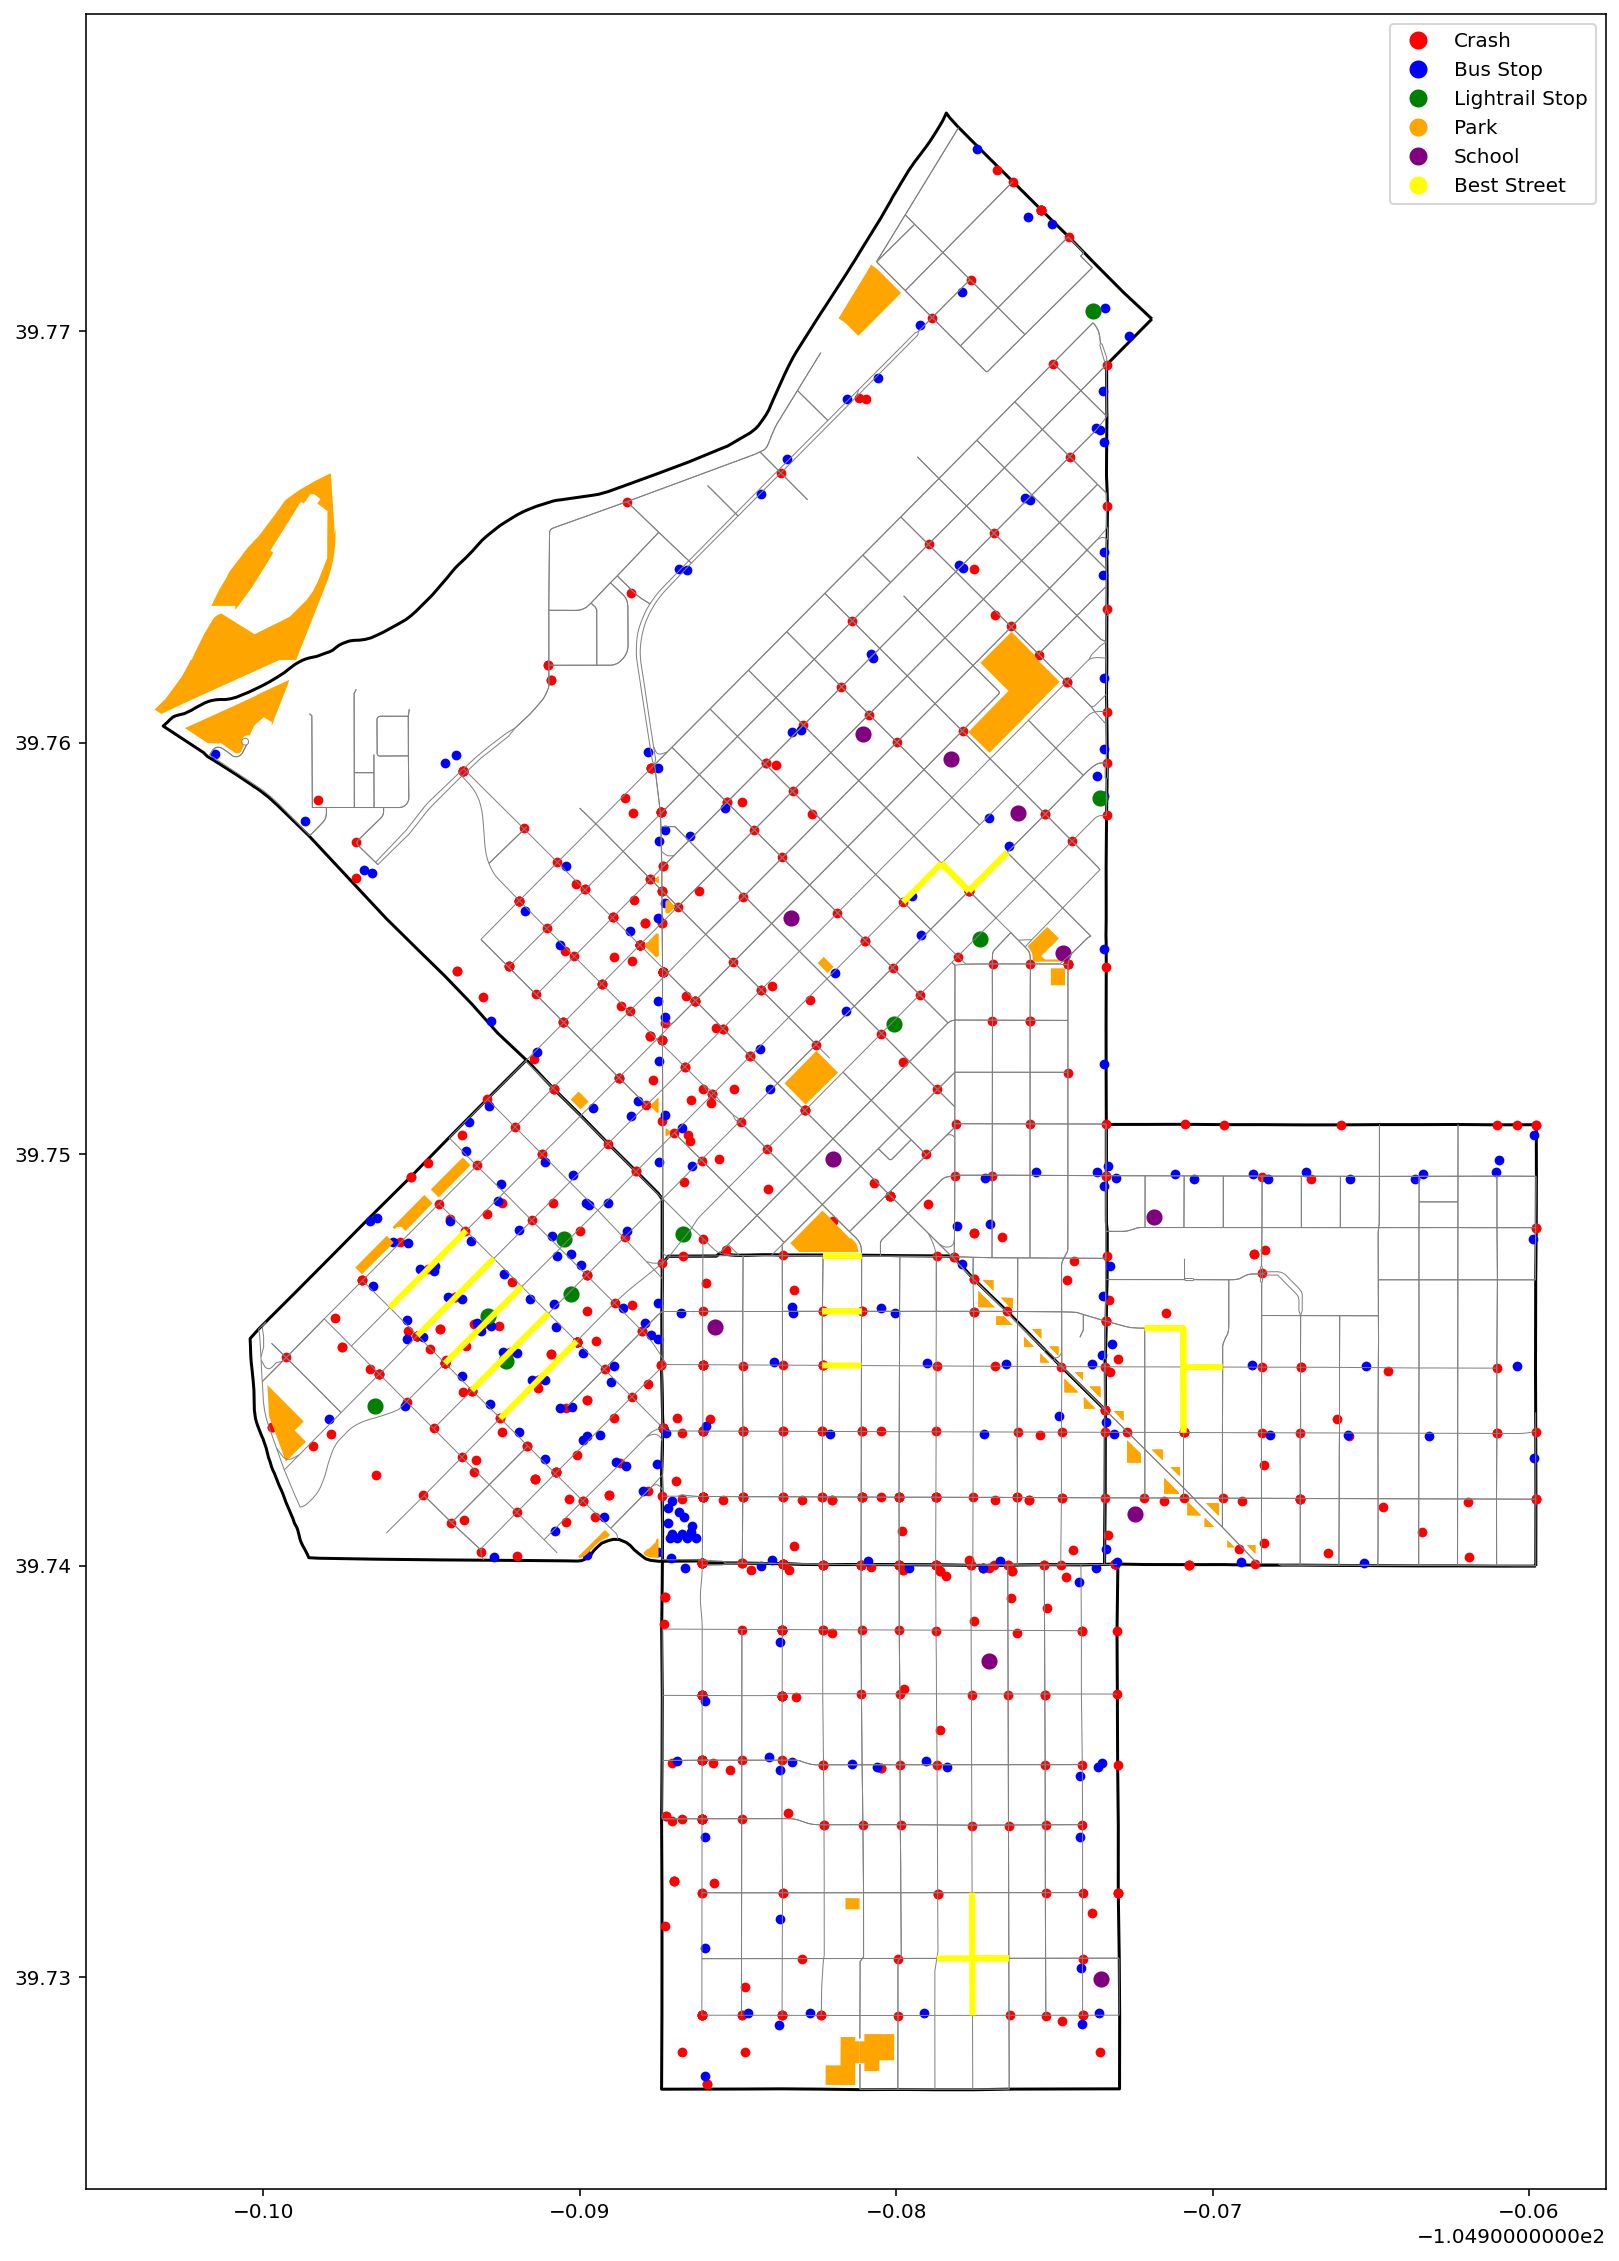

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(20,20), facecolor="white")

legend = [line.Line2D([0],[0],marker='o',color='w',label='Crash', markerfacecolor='red', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Bus Stop', markerfacecolor='blue', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Lightrail Stop', markerfacecolor='green', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Park', markerfacecolor='orange', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='School', markerfacecolor='purple', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Best Street', markerfacecolor='yellow', markersize=10)]
ax.legend(handles=legend)

base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1.5)
street_edges.plot(ax = base, color = "grey", linewidth = 0.5)
crash_data.plot(ax = base, marker = "o", color = "red", markersize = 15)
bus_data.plot(ax = base, marker = "o", color = "blue", markersize = 15)
lightrail_data.plot(ax = base, marker = "o", color = "green", markersize = 50)
park_data.plot(ax = base, color = "orange")
school_data.plot(ax = base, color = "purple", markersize = 50)
best_nch_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_cpw_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_ch_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_fp_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_cbd_streets.plot(ax = base, color = "yellow", linewidth = 3);

## Save the Candidate Streets

In [231]:
# Remove problematic columns and write the data to disk
cols_to_remove = ["osmid", "lanes", "name"]
gpd.GeoDataFrame(
    pd.concat([
        best_nch_streets.drop(cols_to_remove, axis=1),  
        best_cpw_streets.drop(cols_to_remove, axis=1),
        best_ch_streets.drop(cols_to_remove, axis=1),
        best_fp_streets.drop(cols_to_remove, axis=1),
        best_cbd_streets.drop(cols_to_remove, axis=1),
    ])
).to_file("../processed/candidate_streets.shp")

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_94416/4015843993.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd.GeoDataFrame(
